# Avaliação do Plano Diretor

Agora que estimamos a variação na densidade populacional por quadra viária, podemos utilizar essa estimativa para avaliar a eficácia do Plano Diretor no controle dessa variação.

Para isso, vamos avaliar se pertencer a um dos Eixos de Estruturação da Transformação Urbana — que visam potencializar o aproveitamento do solo urbano ao longo da rede de transporte coletivo de média e alta capacidade, bem como buscar a integração territorial das políticas públicas de transporte, habitação, emprego e equipamentos sociais — leva as quadras a ter um aumento na densidade populacional, que é característico da verticalização.

E, além do pertencimento ou não a um Eixos de Estruturação da Transformação Urbana, avaliaremos também a influência de outras variáveis (cofatores) para a redução de possíveis viéses.

# Setup inicial e carregamento dos dados

In [1]:
import logging
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np

from utils.downloads import (
    download_geosampa_shapefile
)

In [2]:
logging.basicConfig(level=logging.INFO)
sns.set_theme(rc={'figure.figsize':(11.7,8.27)})

In [3]:
quadras_estimativa_path = 'data/11_estimativa_quadras.parquet'
quadras = gpd.read_parquet(quadras_estimativa_path)

In [4]:
quadras.head()

,geometry,cd_identificador_quadra_viaria_editada,cd_identificador_quadra_viaria_editada_original,tx_tipo_quadra_viaria,tx_escala,tx_ano_referencia,qt_area_metro,sg_fonte_original,pop_total_prev,pop_total_min,pop_total_max,dom_total_prev,dom_total_min,dom_total_max,dens_10,pop_total,dom_total,dens_22,var_dens
0,"POLYGON ((338344.482 7407584.661, 338344.543 7...",1,52943,Quadra,1:1.000,2004,7650,SMUL/GEOINFO,94.0,0.0,1439.0,29.0,0.0,446.0,12287.581699,154.0,55.0,20130.718954,7843.137255
1,"POLYGON ((327186.316 7377154.793, 327188.886 7...",2,4,Praca_Canteiro,1:1.000,2004,11,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
2,"POLYGON ((324545.386 7402131.104, 324544.170 7...",3,5,Praca_Canteiro,1:1.000,2004,6,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
3,"POLYGON ((326273.589 7399282.971, 326273.013 7...",4,6,Praca_Canteiro,1:1.000,2004,109,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
4,"POLYGON ((322149.447 7392535.031, 322154.771 7...",5,7,Praca_Canteiro,1:1.000,2004,12,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000


In [5]:
SHP_TOMB="14_Patrim%F4nio%20Cultural%5C%5CBens%20Protegidos%5C%5CShapefile%5C%5CSIRGAS_SHP_benstombados"
SHP_BAIRRO_AMB="14_Patrim%F4nio%20Cultural%5C%5CBens%20Protegidos%5C%5CShapefile%5C%5CSIRGAS_SHP_bairroambiental"
SHP_CONTAMIN="24_Licenciamento%20Ambiental%5C%5C%C1rea%20Contaminada%20e%20Reabilitada%5C%5CShapefile%5C%5CSIRGAS_SHP_areacontaminadareabilitada"
SHP_RISCO_GEOLOGICO="07_Prote%E7%E3o%20e%20Defesa%20Civil%5C%5CArea_Risco_Geologico_Atual%5C%5CShapefile%5C%5CSIRGAS_SHP_riscogeologicoatual"
SHP_REST_GEOTECNICA="10_Meio%20F%EDsico%5C%5CRestri%E7%E3o%20Geot%E9cnica%5C%5CShapefile%5C%5CSIRGAS_SHP_restricaogeotecnica"
SHP_REMANESC_MATA="09_Verde%20e%20Recursos%20Naturais\\PMMA\\Shapefile\\SIRGAS_SHP_resevamataatlantica"
SHP_TERRA_INDIGENA="13_Legisla%E7%E3o%20Urbana%5C%5CTerras%20Ind%EDgenas%5C%5CShapefile%5C%5CSIRGAS_SHP_TERRA_INDIGENA"
SHP_PARQUES_UCS="09_Verde%20e%20Recursos%20Naturais\\Cadparcs_Unidades_Conservacao\\Shapefile\\SIRGAS_SHP_CADPARCS_PARQUE_UNIDADE_CONSERVACAO"
SHP_AREA_PUB="12_Cadastro\\Cadastro_Area_Publica\\Shapefile\\SIRGAS_SHP_cadastroareapublica"
SHP_EIXOS="13_Legisla%E7%E3o%20Urbana%5C%5CPDE%5C%5CShapefile%5C%5CPDE_Lei_16050-14_03_Eixos%20de%20Estrutura%E7%E3o%20da%20Transforma%E7%E3o%20Urbana"

shapefiles = {
        'tombamento': {
            'remote_filename': SHP_TOMB,
            'local_filepath': None,
            'shapefile_path': 'SIRGAS_SHP_benstombados/SIRGAS_SHP_benstombados.shp'
        },
        'bairro_amb': {
            'remote_filename': SHP_BAIRRO_AMB,
            'local_filepath': None,
            'shapefile_path': 'SIRGAS_SHP_bairroambiental/SIRGAS_SHP_bairroambiental_polygon.shp'
        },
        'contamin': {
            'remote_filename': SHP_CONTAMIN,
            'local_filepath': None,
            'shapefile_path': 'SIRGAS_SHP_areacontaminadareabilitada/SIRGAS_SHP_areacontaminadareabilitada.shp'
        },
        'risco_geol': {
            'remote_filename': SHP_RISCO_GEOLOGICO,
            'local_filepath': None,
            'shapefile_path': [
                 'SIRGAS_SHP_riscogeologicoatual_AD.shp',
                 'SIRGAS_SHP_riscogeologicoatual_AF.shp',
                 'SIRGAS_SHP_riscogeologicoatual_BT.shp',
                 'SIRGAS_SHP_riscogeologicoatual_CL.shp',
                 'SIRGAS_SHP_riscogeologicoatual_CS.shp',
                 'SIRGAS_SHP_riscogeologicoatual_CT.shp',
                 'SIRGAS_SHP_riscogeologicoatual_CV.shp',
                 'SIRGAS_SHP_riscogeologicoatual_EM.shp',
                 'SIRGAS_SHP_riscogeologicoatual_FO.shp',
                 'SIRGAS_SHP_riscogeologicoatual_G.shp',
                 'SIRGAS_SHP_riscogeologicoatual_IP.shp',
                 'SIRGAS_SHP_riscogeologicoatual_IQ.shp',
                 'SIRGAS_SHP_riscogeologicoatual_IT.shp',
                 'SIRGAS_SHP_riscogeologicoatual_JA.shp',
                 'SIRGAS_SHP_riscogeologicoatual_JT.shp',
                 'SIRGAS_SHP_riscogeologicoatual_LA.shp',
                 'SIRGAS_SHP_riscogeologicoatual_MB.shp',
                 'SIRGAS_SHP_riscogeologicoatual_MG.shp',
                 'SIRGAS_SHP_riscogeologicoatual_MO.shp',
                 'SIRGAS_SHP_riscogeologicoatual_MP.shp',
                 'SIRGAS_SHP_riscogeologicoatual_PA.shp',
                 'SIRGAS_SHP_riscogeologicoatual_PE.shp',
                 'SIRGAS_SHP_riscogeologicoatual_PJ.shp',
                 'SIRGAS_SHP_riscogeologicoatual_PR.shp',
                 'SIRGAS_SHP_riscogeologicoatual_SA.shp',
                 'SIRGAS_SHP_riscogeologicoatual_SB.shp',
                 'SIRGAS_SHP_riscogeologicoatual_SM.shp',
                 'SIRGAS_SHP_riscogeologicoatual_ST.shp',
                 'SIRGAS_SHP_riscogeologicoatual_VP.shp'
            ]
        },
        'risco_geot': {
            'remote_filename': SHP_REST_GEOTECNICA,
            'local_filepath': None,
            'shapefile_path': 'SIRGAS_SHP_restricaogeotecnica/SIRGAS_SHP_restricaogeotecnica.shp'
        },
        'reman_mataatl': {
            'remote_filename': SHP_REMANESC_MATA,
            'local_filepath': None,
            'shapefile_path': 'SIRGAS_SHP_resevamataatlantica/SIRGAS_SHP_resevamataatlantica_polygon.shp'
        },
        'terra_ind': {
            'remote_filename': SHP_TERRA_INDIGENA,
            'local_filepath': None,
            'shapefile_path': 'SIRGAS_SHP_TERRA_INDIGENA/SIRGAS_SHP_TERRA_INDIGENA.shp'
        },
        'parques_ucs': {
            'remote_filename': SHP_PARQUES_UCS,
            'local_filepath': None,
            'shapefile_path': 'SIRGAS_SHP_CADPARCS_PARQUE_UNIDADE_CONSERVACAO/SIRGAS_SHP_CADPARCS_PARQUE_UNIDADE_CONSERVACAO.shp'
        },
        'area_pub': {
            'remote_filename': SHP_AREA_PUB,
            'local_filepath': None,
            'shapefile_path': 'SIRGAS_SHP_cadastroareapublica/SIRGAS_SHP_cadastroareapublica.shp'
        },
        'eixos_etu': {
            'remote_filename': SHP_EIXOS,
            'local_filepath': None,
            'shapefile_path': 'sirgas_PDE_3-Eixos-EETU.shp'
        }
}

In [6]:
for k in shapefiles.keys():
    sf = shapefiles.get(k)
    sf['local_filepath'] = download_geosampa_shapefile(sf['remote_filename'])

INFO:root:O arquivo data/cache/geosampa_shp/SIRGAS_SHP_benstombados.zip já foi baixado anteriormente. Usando cache local.
INFO:root:O arquivo data/cache/geosampa_shp/SIRGAS_SHP_bairroambiental.zip já foi baixado anteriormente. Usando cache local.
INFO:root:O arquivo data/cache/geosampa_shp/SIRGAS_SHP_areacontaminadareabilitada.zip já foi baixado anteriormente. Usando cache local.
INFO:root:O arquivo data/cache/geosampa_shp/SIRGAS_SHP_riscogeologicoatual.zip já foi baixado anteriormente. Usando cache local.
INFO:root:O arquivo data/cache/geosampa_shp/SIRGAS_SHP_restricaogeotecnica.zip já foi baixado anteriormente. Usando cache local.
INFO:root:O arquivo data/cache/geosampa_shp/SIRGAS_SHP_resevamataatlantica.zip já foi baixado anteriormente. Usando cache local.
INFO:root:O arquivo data/cache/geosampa_shp/SIRGAS_SHP_TERRA_INDIGENA.zip já foi baixado anteriormente. Usando cache local.
INFO:root:O arquivo data/cache/geosampa_shp/SIRGAS_SHP_CADPARCS_PARQUE_UNIDADE_CONSERVACAO.zip já foi baix

# Criando a dummy de participação em Eixos de Estruturação da Transformação Urbana

In [7]:
eixos = gpd.read_file(
    f'{shapefiles.get('eixos_etu').get('local_filepath')}!{shapefiles.get('eixos_etu').get('shapefile_path')}'
)
eixos = eixos.set_crs('EPSG:31983')
eixos.head()

,sg_macro_d,cd_perimet,nm_perimet,qt_area_pe,nm_tema_di,tx_macro_d,cd_macro_d,cd_tema_di,geometry
0,EETU,1291,Area de Influencia,3270.1400,Eixos de Estruturação da Transformação Urbana,Eixos da Estruturação da Transformação Urbana,53,3,"POLYGON ((339102.073 7390875.968, 339092.977 7..."
1,EETU,1293,Area de Influencia,10253.8000,Eixos de Estruturação da Transformação Urbana,Eixos da Estruturação da Transformação Urbana,53,3,"POLYGON ((339175.255 7391137.486, 339179.609 7..."
2,EETU,1301,Area de Influencia,13803.7800,Eixos de Estruturação da Transformação Urbana,Eixos da Estruturação da Transformação Urbana,53,3,"POLYGON ((328045.678 7386193.996, 328042.792 7..."
3,EETU,1304,Area de Influencia,1304.1400,Eixos de Estruturação da Transformação Urbana,Eixos da Estruturação da Transformação Urbana,53,3,"POLYGON ((327580.091 7386139.507, 327578.466 7..."
4,EETU,1343,Area de Influencia,18107.1100,Eixos de Estruturação da Transformação Urbana,Eixos da Estruturação da Transformação Urbana,53,3,"POLYGON ((327806.146 7375136.374, 327831.750 7..."


In [8]:
%%time
quadras_eixos = gpd.overlay(
        quadras,
        eixos,
        how='intersection',
        keep_geom_type=True
)
quadras_eixos

CPU times: user 752 ms, sys: 55.6 ms, total: 807 ms
Wall time: 810 ms


,cd_identificador_quadra_viaria_editada,cd_identificador_quadra_viaria_editada_original,tx_tipo_quadra_viaria,tx_escala,tx_ano_referencia,qt_area_metro,sg_fonte_original,pop_total_prev,pop_total_min,pop_total_max,...,var_dens,sg_macro_d,cd_perimet,nm_perimet,qt_area_pe,nm_tema_di,tx_macro_d,cd_macro_d,cd_tema_di,geometry
0,130,171,Praca_Canteiro,1:1.000,2004,1600,SMUL/GEOINFO,0.0,0.0,0.0,...,0.000000,EETU,2040,Area de Influencia,16006.3400,Eixos de Estruturação da Transformação Urbana,Eixos da Estruturação da Transformação Urbana,53,3,"POLYGON ((356469.572 7401103.257, 356469.570 7..."
1,187,247,Quadra,1:1.000,2017,34359,SMUL/GEOINFO,409.0,0.0,786.0,...,-6082.831281,EETU,1616,Area de Influencia,21405.2000,Eixos de Estruturação da Transformação Urbana,Eixos da Estruturação da Transformação Urbana,53,3,"POLYGON ((345576.802 7397270.692, 345578.146 7..."
2,187,247,Quadra,1:1.000,2017,34359,SMUL/GEOINFO,409.0,0.0,786.0,...,-6082.831281,EETU,1617,Area de Influencia,21405.2000,Eixos de Estruturação da Transformação Urbana,Eixos da Estruturação da Transformação Urbana,53,3,"POLYGON ((345576.802 7397270.692, 345578.146 7..."
3,188,248,Quadra,1:1.000,2017,3446,SMUL/GEOINFO,43.0,0.0,786.0,...,-6384.213581,EETU,391,Area de Influencia,2453.4800,Eixos de Estruturação da Transformação Urbana,Eixos da Estruturação da Transformação Urbana,53,3,"POLYGON ((345402.230 7397291.473, 345401.828 7..."
4,188,248,Quadra,1:1.000,2017,3446,SMUL/GEOINFO,43.0,0.0,786.0,...,-6384.213581,EETU,1616,Area de Influencia,21405.2000,Eixos de Estruturação da Transformação Urbana,Eixos da Estruturação da Transformação Urbana,53,3,"POLYGON ((345472.815 7397273.663, 345471.983 7..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5305,64668,75193,Quadra,1:1.000,2017,124074,SMUL/GEOINFO,1066.0,598.0,1891.0,...,282.089721,EETU,1092,Area de Influencia,6510.8700,Eixos de Estruturação da Transformação Urbana,Eixos da Estruturação da Transformação Urbana,53,3,"POLYGON ((351335.837 7389154.314, 351337.467 7..."
5306,64750,83000,Praca_Canteiro,1:1.000,2017,1908,SMUL/GEOINFO,0.0,0.0,0.0,...,0.000000,EETU,4540,Area de Influencia,2622.8300,Eixos de Estruturação da Transformação Urbana,Eixos da Estruturação da Transformação Urbana,53,3,"POLYGON ((321658.879 7380598.598, 321658.628 7..."
5307,64751,83000,Praca_Canteiro,1:1.000,2017,1908,SMUL/GEOINFO,0.0,0.0,0.0,...,0.000000,EETU,4925,Area de Influencia,2507.2000,Eixos de Estruturação da Transformação Urbana,Eixos da Estruturação da Transformação Urbana,53,3,"POLYGON ((321545.637 7380515.630, 321542.000 7..."
5308,64751,83000,Praca_Canteiro,1:1.000,2017,1908,SMUL/GEOINFO,0.0,0.0,0.0,...,0.000000,EETU,4928,Area de Influencia,17901.6300,Eixos de Estruturação da Transformação Urbana,Eixos da Estruturação da Transformação Urbana,53,3,"MULTIPOLYGON (((321522.486 7380516.588, 321502..."


In [9]:
quadras = (
    quadras
    .assign(
        in_eixo=quadras['cd_identificador_quadra_viaria_editada'].isin(quadras_eixos['cd_identificador_quadra_viaria_editada'])
    )
)
quadras

,geometry,cd_identificador_quadra_viaria_editada,cd_identificador_quadra_viaria_editada_original,tx_tipo_quadra_viaria,tx_escala,tx_ano_referencia,qt_area_metro,sg_fonte_original,pop_total_prev,pop_total_min,pop_total_max,dom_total_prev,dom_total_min,dom_total_max,dens_10,pop_total,dom_total,dens_22,var_dens,in_eixo
0,"POLYGON ((338344.482 7407584.661, 338344.543 7...",1,52943,Quadra,1:1.000,2004,7650,SMUL/GEOINFO,94.0,0.0,1439.0,29.0,0.0,446.0,12287.581699,154.0,55.0,20130.718954,7843.137255,False
1,"POLYGON ((327186.316 7377154.793, 327188.886 7...",2,4,Praca_Canteiro,1:1.000,2004,11,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,False
2,"POLYGON ((324545.386 7402131.104, 324544.170 7...",3,5,Praca_Canteiro,1:1.000,2004,6,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,False
3,"POLYGON ((326273.589 7399282.971, 326273.013 7...",4,6,Praca_Canteiro,1:1.000,2004,109,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,False
4,"POLYGON ((322149.447 7392535.031, 322154.771 7...",5,7,Praca_Canteiro,1:1.000,2004,12,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64779,"POLYGON ((325071.550 7397335.276, 325073.371 7...",64780,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,False
64780,"POLYGON ((325064.631 7397341.102, 325065.814 7...",64781,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,False
64781,"POLYGON ((325102.327 7397333.002, 325089.121 7...",64782,58914,Praca_Canteiro,1:1.000,2004,25982,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,False
64782,"POLYGON ((325081.631 7397226.147, 325087.148 7...",64783,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,False


# Criando as dummies de cofatores

## Bens tombados

In [10]:
tombamento = gpd.read_file(
    f'{shapefiles.get('tombamento').get('local_filepath')}!{shapefiles.get('tombamento').get('shapefile_path')}'
)
tombamento = tombamento.set_crs('EPSG:31983')
tombamento.head()

,bp_id,bp_nome,bp_setor,bp_quadra,bp_lote,bp_cond,bp_compres,bp_condeph,bp_iphan,bp_enderec,...,bp_tpcateg,bp_categor,bp_status,bp_distrit,bp_subpref,bp_proconp,bp_procond,bp_proipha,bp_obscomp,geometry
0,None,BAIRRO DA BELA VISTA,005,086,0059,00,RES. 22/02,não consta,não consta,"R CONDE DE SÃO JOAQUIM, 231",...,BIR,Bens Imóveis Representativos,TOMBADO,BELA VISTA,SÉ,1990-0.004.514-2,None,não consta,None,"POLYGON ((332719.960 7393752.388, 332729.855 7..."
1,None,CONGREGAÇÃO PEQUENAS IRMAS DIVINA PROVIDENCIA ...,003,034,0024,00,RES. 06/16,não consta,não consta,"R WANDENKOLK, 514",...,None,None,TOMBADO,BRÁS,SÉ,None,None,não consta,None,"POLYGON ((334258.178 7394302.924, 334243.304 7..."
2,None,FÁBRICA LABOR,003,045,0044,00,RES. 22/17,RES. SC 101/2014,não consta,"R DA MOOCA, 699",...,None,None,TOMBADO,BRÁS,SÉ,None,None,não consta,None,"POLYGON ((334773.813 7394273.337, 334803.080 7..."
3,None,CONGREGAÇÃO PEQUENAS IRMAS DIVINA PROVIDENCIA ...,003,034,0001,00,RES. 06/16,não consta,não consta,"R DA MOOCA, 93",...,None,None,TOMBADO,BRÁS,SÉ,None,None,não consta,None,"POLYGON ((334206.659 7394316.266, 334207.600 7..."
4,None,FÁBRICA LABOR,003,045,0043,00,RES. 14/14,RES. SC 101/2014,não consta,"R DA MOOCA, 775",...,None,None,TOMBADO,BRÁS,SÉ,None,não consta,não consta,None,"POLYGON ((334818.066 7394350.141, 334839.449 7..."


In [11]:
tombamento.bp_status.value_counts()

bp_status
TOMBADO         5738
APT             1010
APT / ESTUDO     214
Name: count, dtype: int64

Como a Resolução de Abertura de Tombamento (APT) confere ao bem o mesmo regime de preservação do bem tombado até a decisão final do Conselho, a presença de qualquer status reduz a possibilidade de construção na quadra, não necessitando nenhum filtro adicional antes da interseção geográfica.

In [12]:
%%time
quadras_tombamento = gpd.overlay(
        quadras,
        tombamento,
        how='intersection',
        keep_geom_type=True
)
quadras_tombamento

CPU times: user 1.12 s, sys: 44.3 ms, total: 1.17 s
Wall time: 1.17 s


,cd_identificador_quadra_viaria_editada,cd_identificador_quadra_viaria_editada_original,tx_tipo_quadra_viaria,tx_escala,tx_ano_referencia,qt_area_metro,sg_fonte_original,pop_total_prev,pop_total_min,pop_total_max,...,bp_tpcateg,bp_categor,bp_status,bp_distrit,bp_subpref,bp_proconp,bp_procond,bp_proipha,bp_obscomp,geometry
0,225,290,Praca_Canteiro,1:1.000,2004,13,SMUL/GEOINFO,0.0,0.0,0.0,...,None,None,TOMBADO,None,None,6025.2020/0028014-5,None,None,None,"POLYGON ((332172.998 7395123.476, 332171.989 7..."
1,678,870,Quadra,1:1.000,2004,17744,SMUL/GEOINFO,85.0,0.0,569.0,...,BIR,Bens Imóveis Representativos,TOMBADO,JARDIM PAULISTA,SÉ,2009-0.064.434-2 e 2017-0.144.142-6,não consta,não consta,None,"POLYGON ((330163.567 7391816.371, 330166.522 7..."
2,727,926,Quadra,1:1.000,2017,1194,SMUL/GEOINFO,9.0,0.0,1059.0,...,None,None,TOMBADO,PENHA,PE,2007-0.301.455-1; 2004-0.297.171-6; 2005-0.059...,não consta,não consta,None,"POLYGON ((341759.115 7397336.388, 341778.211 7..."
3,727,926,Quadra,1:1.000,2017,1194,SMUL/GEOINFO,9.0,0.0,1059.0,...,None,None,TOMBADO,PENHA,PE,None,não consta,não consta,None,"POLYGON ((341759.115 7397336.388, 341778.212 7..."
4,727,926,Quadra,1:1.000,2017,1194,SMUL/GEOINFO,9.0,0.0,1059.0,...,None,None,TOMBADO,PENHA,PE,2007-0.301.455-1; 2004-0.297.171-6; 2005-0.059...,não consta,não consta,None,"POLYGON ((341800.290 7397349.085, 341801.441 7..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7845,64659,98041,Quadra,1:1.000,2017,427,SMUL/GEOINFO,0.0,0.0,21.0,...,None,None,TOMBADO,PARELHEIROS,VÁRIOS,None,None,não consta,None,"POLYGON ((326558.202 7359745.191, 326553.245 7..."
7846,64660,98041,Quadra,1:1.000,2017,97857,SMUL/GEOINFO,276.0,0.0,2357.0,...,None,None,TOMBADO,PARELHEIROS,VÁRIOS,None,None,não consta,None,"POLYGON ((326553.724 7359745.170, 326551.317 7..."
7847,64661,98041,Quadra,1:1.000,2017,8818,SMUL/GEOINFO,88.0,0.0,2336.0,...,None,None,TOMBADO,PARELHEIROS,VÁRIOS,None,None,não consta,None,"POLYGON ((326539.960 7359873.744, 326534.699 7..."
7848,64662,98041,Quadra,1:1.000,2017,255,SMUL/GEOINFO,3.0,0.0,2336.0,...,None,None,TOMBADO,PARELHEIROS,VÁRIOS,None,None,não consta,None,"POLYGON ((326595.376 7359875.528, 326595.685 7..."


In [13]:
quadras = (
    quadras
    .assign(
        has_tombamento=quadras['cd_identificador_quadra_viaria_editada'].isin(quadras_tombamento['cd_identificador_quadra_viaria_editada'])
    )
)
quadras

,geometry,cd_identificador_quadra_viaria_editada,cd_identificador_quadra_viaria_editada_original,tx_tipo_quadra_viaria,tx_escala,tx_ano_referencia,qt_area_metro,sg_fonte_original,pop_total_prev,pop_total_min,...,dom_total_prev,dom_total_min,dom_total_max,dens_10,pop_total,dom_total,dens_22,var_dens,in_eixo,has_tombamento
0,"POLYGON ((338344.482 7407584.661, 338344.543 7...",1,52943,Quadra,1:1.000,2004,7650,SMUL/GEOINFO,94.0,0.0,...,29.0,0.0,446.0,12287.581699,154.0,55.0,20130.718954,7843.137255,False,False
1,"POLYGON ((327186.316 7377154.793, 327188.886 7...",2,4,Praca_Canteiro,1:1.000,2004,11,SMUL/GEOINFO,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,False,False
2,"POLYGON ((324545.386 7402131.104, 324544.170 7...",3,5,Praca_Canteiro,1:1.000,2004,6,SMUL/GEOINFO,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,False,False
3,"POLYGON ((326273.589 7399282.971, 326273.013 7...",4,6,Praca_Canteiro,1:1.000,2004,109,SMUL/GEOINFO,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,False,False
4,"POLYGON ((322149.447 7392535.031, 322154.771 7...",5,7,Praca_Canteiro,1:1.000,2004,12,SMUL/GEOINFO,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64779,"POLYGON ((325071.550 7397335.276, 325073.371 7...",64780,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,False,False
64780,"POLYGON ((325064.631 7397341.102, 325065.814 7...",64781,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,False,False
64781,"POLYGON ((325102.327 7397333.002, 325089.121 7...",64782,58914,Praca_Canteiro,1:1.000,2004,25982,SMUL/GEOINFO,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,False,False
64782,"POLYGON ((325081.631 7397226.147, 325087.148 7...",64783,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,False,False


## Bairros ambientais

In [14]:
bairro_amb = gpd.read_file(
    f'{shapefiles.get('bairro_amb').get('local_filepath')}!{shapefiles.get('bairro_amb').get('shapefile_path')}'
)
bairro_amb = bairro_amb.set_crs('EPSG:31983')
bairro_amb.head()

,ba_conpres,ba_link,ba_condeph,ba_fonte,ba_tipo,ba_nome,geometry
0,RES. 05/1991; RES. 07/2004 (DETALHAMENTO E COM...,https://www.prefeitura.sp.gov.br/cidade/upload...,RES. SC 02/1986; RES. COMPL. SCEC 37/2021,DPH/SMC,Bairro Ambiental,"JARDINS: AMÉRICA, EUROPA, PAULISTA E PAULISTANO","POLYGON ((329046.578 7393234.733, 329087.797 7..."
1,RES. 42/1992; RES. 09/2015 (COMPLEMENTAÇÃO),https://www.prefeitura.sp.gov.br/cidade/upload...,RES. SC 08/1991; RES. SC 12/2008 (COMPLEMENTAÇÃO),DPH/SMC,Bairro Ambiental,BAIRROS DO PACAEMBU E PERDIZES,"POLYGON ((329792.196 7394016.673, 329898.306 7..."
2,RES. 03/2009,https://www.prefeitura.sp.gov.br/cidade/upload...,não consta,DPH/SMC,Bairro Ambiental,CITY LAPA,"POLYGON ((325934.738 7397438.298, 325896.035 7..."
3,RES. 05/2002,https://www.prefeitura.sp.gov.br/cidade/upload...,não consta,DPH/SMC,Bairro Ambiental,ÁREA DO JARDIM LUSITÂNIA,"POLYGON ((331017.358 7389806.206, 331042.434 7..."
4,RES. 16/2002,https://www.prefeitura.sp.gov.br/cidade/upload...,não consta,DPH/SMC,Bairro Ambiental,ÁREA DO JARDIM DA SAUDE,"POLYGON ((334105.926 7386889.038, 334073.650 7..."


In [15]:
%%time
quadras_bamb = gpd.overlay(
        quadras,
        bairro_amb,
        how='intersection',
        keep_geom_type=True
)
quadras_bamb

CPU times: user 476 ms, sys: 11.9 ms, total: 488 ms
Wall time: 488 ms


,cd_identificador_quadra_viaria_editada,cd_identificador_quadra_viaria_editada_original,tx_tipo_quadra_viaria,tx_escala,tx_ano_referencia,qt_area_metro,sg_fonte_original,pop_total_prev,pop_total_min,pop_total_max,...,var_dens,in_eixo,has_tombamento,ba_conpres,ba_link,ba_condeph,ba_fonte,ba_tipo,ba_nome,geometry
0,7,10,Praca_Canteiro,1:1.000,2004,563,SMUL/GEOINFO,0.0,0.0,0.0,...,0.0,False,False,RES. 05/1991; RES. 07/2004 (DETALHAMENTO E COM...,https://www.prefeitura.sp.gov.br/cidade/upload...,RES. SC 02/1986; RES. COMPL. SCEC 37/2021,DPH/SMC,Bairro Ambiental,"JARDINS: AMÉRICA, EUROPA, PAULISTA E PAULISTANO","POLYGON ((329175.775 7391565.401, 329212.595 7..."
1,15,24,Praca_Canteiro,1:1.000,2004,17,SMUL/GEOINFO,0.0,0.0,0.0,...,0.0,False,False,RES. 16/2002,https://www.prefeitura.sp.gov.br/cidade/upload...,não consta,DPH/SMC,Bairro Ambiental,ÁREA DO JARDIM DA SAUDE,"POLYGON ((334653.251 7386813.358, 334653.327 7..."
2,17,27,Praca_Canteiro,1:1.000,2004,9,SMUL/GEOINFO,0.0,0.0,0.0,...,0.0,False,False,RES. 16/2002,https://www.prefeitura.sp.gov.br/cidade/upload...,não consta,DPH/SMC,Bairro Ambiental,ÁREA DO JARDIM DA SAUDE,"POLYGON ((334669.967 7386823.263, 334669.453 7..."
3,18,29,Praca_Canteiro,1:1.000,2004,10,SMUL/GEOINFO,0.0,0.0,0.0,...,0.0,False,False,RES. 16/2002,https://www.prefeitura.sp.gov.br/cidade/upload...,não consta,DPH/SMC,Bairro Ambiental,ÁREA DO JARDIM DA SAUDE,"POLYGON ((334643.309 7386825.410, 334643.118 7..."
4,19,30,Praca_Canteiro,1:1.000,2004,11,SMUL/GEOINFO,0.0,0.0,0.0,...,0.0,False,False,RES. 16/2002,https://www.prefeitura.sp.gov.br/cidade/upload...,não consta,DPH/SMC,Bairro Ambiental,ÁREA DO JARDIM DA SAUDE,"POLYGON ((335286.364 7387720.988, 335286.334 7..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1348,64779,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,0.0,...,0.0,False,False,RES. 03/2009,https://www.prefeitura.sp.gov.br/cidade/upload...,não consta,DPH/SMC,Bairro Ambiental,CITY LAPA,"POLYGON ((325056.710 7397327.446, 325050.884 7..."
1349,64780,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,0.0,...,0.0,False,False,RES. 03/2009,https://www.prefeitura.sp.gov.br/cidade/upload...,não consta,DPH/SMC,Bairro Ambiental,CITY LAPA,"POLYGON ((325073.371 7397334.639, 325075.009 7..."
1350,64781,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,0.0,...,0.0,False,False,RES. 03/2009,https://www.prefeitura.sp.gov.br/cidade/upload...,não consta,DPH/SMC,Bairro Ambiental,CITY LAPA,"POLYGON ((325065.814 7397348.659, 325066.361 7..."
1351,64782,58914,Praca_Canteiro,1:1.000,2004,25982,SMUL/GEOINFO,0.0,0.0,0.0,...,0.0,False,False,RES. 03/2009,https://www.prefeitura.sp.gov.br/cidade/upload...,não consta,DPH/SMC,Bairro Ambiental,CITY LAPA,"POLYGON ((325089.121 7397330.178, 325083.021 7..."


In [16]:
quadras = (
    quadras
    .assign(
        in_bairro_ambiental=quadras['cd_identificador_quadra_viaria_editada'].isin(quadras_bamb['cd_identificador_quadra_viaria_editada'])
    )
)
quadras

,geometry,cd_identificador_quadra_viaria_editada,cd_identificador_quadra_viaria_editada_original,tx_tipo_quadra_viaria,tx_escala,tx_ano_referencia,qt_area_metro,sg_fonte_original,pop_total_prev,pop_total_min,...,dom_total_min,dom_total_max,dens_10,pop_total,dom_total,dens_22,var_dens,in_eixo,has_tombamento,in_bairro_ambiental
0,"POLYGON ((338344.482 7407584.661, 338344.543 7...",1,52943,Quadra,1:1.000,2004,7650,SMUL/GEOINFO,94.0,0.0,...,0.0,446.0,12287.581699,154.0,55.0,20130.718954,7843.137255,False,False,False
1,"POLYGON ((327186.316 7377154.793, 327188.886 7...",2,4,Praca_Canteiro,1:1.000,2004,11,SMUL/GEOINFO,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,False,False,False
2,"POLYGON ((324545.386 7402131.104, 324544.170 7...",3,5,Praca_Canteiro,1:1.000,2004,6,SMUL/GEOINFO,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,False,False,False
3,"POLYGON ((326273.589 7399282.971, 326273.013 7...",4,6,Praca_Canteiro,1:1.000,2004,109,SMUL/GEOINFO,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,False,False,False
4,"POLYGON ((322149.447 7392535.031, 322154.771 7...",5,7,Praca_Canteiro,1:1.000,2004,12,SMUL/GEOINFO,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64779,"POLYGON ((325071.550 7397335.276, 325073.371 7...",64780,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,False,False,True
64780,"POLYGON ((325064.631 7397341.102, 325065.814 7...",64781,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,False,False,True
64781,"POLYGON ((325102.327 7397333.002, 325089.121 7...",64782,58914,Praca_Canteiro,1:1.000,2004,25982,SMUL/GEOINFO,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,False,False,True
64782,"POLYGON ((325081.631 7397226.147, 325087.148 7...",64783,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,False,False,True


## Área contaminada

Áreas Contaminadas e Reabilitadas, de acordo com a Lei Municipal nº 15.098/2010, que dispõe sobre a publicação do Relatório de Áreas Contaminadas e Reabilitadas no Município pela Secretaria Municipal do Verde e do Meio Ambiente – SVMA. O mapeamento foi elaborado de acordo com os lotes do Geosampa. Os vértices dos lotes foram simplificados para a elaboração do relatório e os SQLs limítrofes foram dissolvidos de acordo com cada área. Para imóveis rurais foram utilizados dados do Acervo Fundiário do INCRA e/ou dos projetos constantes nos respectivos Processos.

Todas os registros estão ativos, então não é necessário nenhum filtro relacionado ao status. Porém, algumas geometrias não estão válidas, e esses registro serão removidos do GeoDataFrame.

In [17]:
contamin = gpd.read_file(
    f'{shapefiles.get('contamin').get('local_filepath')}!{shapefiles.get('contamin').get('shapefile_path')}'
)
contamin = contamin.set_crs('EPSG:31983')
contamin.head()

,acr_cep,acr_id_ori,acr_classf,acr_terren,acr_usoant,acr_usopre,acr_dtatua,acr_dt_inc,acr_dt_cad,acr_cetesb,acr_sigac,acr_sipol,acr_contam,acr_endere,acr_interv,acr_restri,geometry
0,05311000,76,Reabilitada,Particular,Indústria,Uso Residencial,2024-04-05,2010-11-22,2018-05-07,Sim,Não,Não,Gases,"Avenida Mofarrej, 275","Extração de vapores do solo (SVE), Monitoramen...",Água Subterrânea,"POLYGON ((322487.615 7397156.528, 322590.773 7..."
1,04047002,596,Contaminada Sob Investigação,Particular,Posto de Combustível,Uso Residencial,2024-04-05,2015-08-21,2018-05-11,Sim,Sim,Sim,Solventes Aromáticos,"Avenida Senador Casimiro da Rocha, 840",None,Água Subterrânea,"POLYGON ((332469.880 7388103.233, 332445.819 7..."
2,05092040,395,Reabilitada,Particular,Transportadora,Uso Residencial,2024-04-05,2013-05-02,2018-05-09,Sim,Sim,Não,"Metais, PAH's, Solventes Aromáticos, TPH","Avenida Raimundo Pereira de Magalhães, 817","Bombeamento e tratamento, Oxidação/redução quí...","Água Subterrânea, Interceptação do Lençol Freá...","POLYGON ((324851.187 7398712.291, 324965.478 7..."
3,03073050,745,Contaminada Sob Investigação,Particular,Atividade potencial,Uso Residencial,2024-04-05,2017-04-06,2018-05-11,Não,Sim,Sim,Outros,"Rua Santa Teresinha, 204; Rua Adelino de Almei...",None,None,"POLYGON ((341169.478 7396683.652, 341196.989 7..."
4,05311000,774,Contaminada,Particular,Desconhecida,Uso Não Residencial,2024-04-05,2017-10-24,2018-05-09,Não,Não,Não,Metais,"Avenida Mofarrej, 1267",None,None,"POLYGON ((322043.494 7396506.357, 322098.135 7..."


In [18]:
contamin[['acr_classf']].value_counts()

acr_classf                                    
Reabilitada                                       268
Contaminada Sob Investigação                      202
Contaminada                                       188
Em Processo de Monitoramento para Reabilitação     71
Name: count, dtype: int64

Áreas reabilitadas não possuem nenhuma interferência no processo de edificação, então serão removidas do dataframe.

In [19]:
contamin = contamin[contamin['acr_classf']!='Reabilitada']
contamin[['acr_classf']].value_counts()

acr_classf                                    
Contaminada Sob Investigação                      202
Contaminada                                       188
Em Processo de Monitoramento para Reabilitação     71
Name: count, dtype: int64

In [20]:
contamin['geometry'].is_valid.value_counts()

True    461
Name: count, dtype: int64

Todas as geometrias são válidas, então nenhum filtro precisa ser feito em relação a isso.

In [21]:
%%time
quadras_contamin = gpd.overlay(
        quadras,
        contamin,
        how='intersection',
        keep_geom_type=True
)
quadras_contamin

CPU times: user 565 ms, sys: 22.5 ms, total: 587 ms
Wall time: 588 ms


,cd_identificador_quadra_viaria_editada,cd_identificador_quadra_viaria_editada_original,tx_tipo_quadra_viaria,tx_escala,tx_ano_referencia,qt_area_metro,sg_fonte_original,pop_total_prev,pop_total_min,pop_total_max,...,acr_dt_inc,acr_dt_cad,acr_cetesb,acr_sigac,acr_sipol,acr_contam,acr_endere,acr_interv,acr_restri,geometry
0,546,694,Quadra,1:1.000,2004,80,SMUL/GEOINFO,0.0,0.0,29.0,...,2010-11-22,2018-05-07,Sim,Sim,Não,"Metais, PAH's, PCB's, Solventes Aromáticos Hal...","Avenida Nossa Senhora do Sabará, 5312","Monitoramento ambiental, Remoção de solo/resíduo",None,"POLYGON ((329265.449 7377726.664, 329265.599 7..."
1,838,1125,Quadra,1:1.000,2017,134485,SMUL/GEOINFO,172.0,0.0,2143.0,...,2010-11-22,2022-12-22,Sim,Sim,Não,Metais,"Avenida Dr. José Artur Nova, 1309","Barreira hidráulica, Bombeamento e tratamento,...","Água Subterrânea, Solo","POLYGON ((353129.290 7402579.440, 353121.871 7..."
2,850,1158,Quadra,1:1.000,2017,818123,SMUL/GEOINFO,973.0,0.0,1858.0,...,2016-07-15,2020-01-21,Sim,Sim,Não,"Metais, Solventes Halogenados, TPH","Avenida das Nações Unidas, 22540",None,Água Subterrânea,"POLYGON ((326720.575 7380601.337, 326721.575 7..."
3,850,1158,Quadra,1:1.000,2017,818123,SMUL/GEOINFO,973.0,0.0,1858.0,...,2010-11-22,2018-05-10,Sim,Sim,Não,"Metais, Solventes Halogenados, TPH","Avenida das Nações Unidas, 22002",None,Água Subterrânea,"POLYGON ((326408.984 7380621.939, 326475.044 7..."
4,850,1158,Quadra,1:1.000,2017,818123,SMUL/GEOINFO,973.0,0.0,1858.0,...,2012-03-06,2018-05-10,Sim,Sim,Sim,"Metais, Solventes Aromáticos, Solventes Haloge...","Avenida das Nações Unidas, 21612",Remoção de fase livre,"Água Subterrânea, Solo, Subsolo","POLYGON ((326141.653 7380936.399, 326066.513 7..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
587,64577,34522,Quadra,1:1.000,2004,85679,SMUL/GEOINFO,280.0,0.0,1340.0,...,2010-11-22,2022-12-22,Sim,Sim,Não,Metais,"Estrada do Alvarenga, 5071","Bombeamento e tratamento, Monitoramento ambiental",Água Subterrânea,"POLYGON ((333287.703 7376648.765, 333258.643 7..."
588,64664,1844,Quadra,1:1.000,2017,19478,SMUL/GEOINFO,21.0,0.0,804.0,...,2018-10-24,2022-12-22,Sim,Sim,Não,"Gases, Metais, PAH's, PCB's","Rua André de Almeida, s/n, 2375 e 2481","Impermeabilização de Solo/Resíduo, Monitoramen...","Água Subterrânea, Construção de Espaços Confin...","POLYGON ((349626.720 7389560.091, 349722.405 7..."
589,64665,1844,Praca_Canteiro,1:1.000,2017,40,SMUL/GEOINFO,0.0,0.0,0.0,...,2018-10-24,2022-12-22,Sim,Sim,Não,"Gases, Metais, PAH's, PCB's","Rua André de Almeida, s/n, 2375 e 2481","Impermeabilização de Solo/Resíduo, Monitoramen...","Água Subterrânea, Construção de Espaços Confin...","POLYGON ((349668.334 7389523.856, 349672.006 7..."
590,64666,1844,Quadra,1:1.000,2017,424007,SMUL/GEOINFO,461.0,0.0,804.0,...,2018-10-24,2022-12-22,Sim,Sim,Não,"Gases, Metais, PAH's, PCB's","Rua André de Almeida, s/n, 2375 e 2481","Impermeabilização de Solo/Resíduo, Monitoramen...","Água Subterrânea, Construção de Espaços Confin...","POLYGON ((349679.924 7389513.069, 349678.776 7..."


In [22]:
quadras_contamin = (
    quadras_contamin
    .merge(
        quadras
        .assign(quadra_geom_area=quadras.geometry.area)
        [['cd_identificador_quadra_viaria_editada', 'quadra_geom_area']]
    )
)
quadras_contamin

,cd_identificador_quadra_viaria_editada,cd_identificador_quadra_viaria_editada_original,tx_tipo_quadra_viaria,tx_escala,tx_ano_referencia,qt_area_metro,sg_fonte_original,pop_total_prev,pop_total_min,pop_total_max,...,acr_dt_cad,acr_cetesb,acr_sigac,acr_sipol,acr_contam,acr_endere,acr_interv,acr_restri,geometry,quadra_geom_area
0,546,694,Quadra,1:1.000,2004,80,SMUL/GEOINFO,0.0,0.0,29.0,...,2018-05-07,Sim,Sim,Não,"Metais, PAH's, PCB's, Solventes Aromáticos Hal...","Avenida Nossa Senhora do Sabará, 5312","Monitoramento ambiental, Remoção de solo/resíduo",None,"POLYGON ((329265.449 7377726.664, 329265.599 7...",80.775849
1,838,1125,Quadra,1:1.000,2017,134485,SMUL/GEOINFO,172.0,0.0,2143.0,...,2022-12-22,Sim,Sim,Não,Metais,"Avenida Dr. José Artur Nova, 1309","Barreira hidráulica, Bombeamento e tratamento,...","Água Subterrânea, Solo","POLYGON ((353129.290 7402579.440, 353121.871 7...",134450.297870
2,850,1158,Quadra,1:1.000,2017,818123,SMUL/GEOINFO,973.0,0.0,1858.0,...,2020-01-21,Sim,Sim,Não,"Metais, Solventes Halogenados, TPH","Avenida das Nações Unidas, 22540",None,Água Subterrânea,"POLYGON ((326720.575 7380601.337, 326721.575 7...",818076.335475
3,850,1158,Quadra,1:1.000,2017,818123,SMUL/GEOINFO,973.0,0.0,1858.0,...,2018-05-10,Sim,Sim,Não,"Metais, Solventes Halogenados, TPH","Avenida das Nações Unidas, 22002",None,Água Subterrânea,"POLYGON ((326408.984 7380621.939, 326475.044 7...",818076.335475
4,850,1158,Quadra,1:1.000,2017,818123,SMUL/GEOINFO,973.0,0.0,1858.0,...,2018-05-10,Sim,Sim,Sim,"Metais, Solventes Aromáticos, Solventes Haloge...","Avenida das Nações Unidas, 21612",Remoção de fase livre,"Água Subterrânea, Solo, Subsolo","POLYGON ((326141.653 7380936.399, 326066.513 7...",818076.335475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
587,64577,34522,Quadra,1:1.000,2004,85679,SMUL/GEOINFO,280.0,0.0,1340.0,...,2022-12-22,Sim,Sim,Não,Metais,"Estrada do Alvarenga, 5071","Bombeamento e tratamento, Monitoramento ambiental",Água Subterrânea,"POLYGON ((333287.703 7376648.765, 333258.643 7...",85669.227683
588,64664,1844,Quadra,1:1.000,2017,19478,SMUL/GEOINFO,21.0,0.0,804.0,...,2022-12-22,Sim,Sim,Não,"Gases, Metais, PAH's, PCB's","Rua André de Almeida, s/n, 2375 e 2481","Impermeabilização de Solo/Resíduo, Monitoramen...","Água Subterrânea, Construção de Espaços Confin...","POLYGON ((349626.720 7389560.091, 349722.405 7...",19473.961707
589,64665,1844,Praca_Canteiro,1:1.000,2017,40,SMUL/GEOINFO,0.0,0.0,0.0,...,2022-12-22,Sim,Sim,Não,"Gases, Metais, PAH's, PCB's","Rua André de Almeida, s/n, 2375 e 2481","Impermeabilização de Solo/Resíduo, Monitoramen...","Água Subterrânea, Construção de Espaços Confin...","POLYGON ((349668.334 7389523.856, 349672.006 7...",40.286962
590,64666,1844,Quadra,1:1.000,2017,424007,SMUL/GEOINFO,461.0,0.0,804.0,...,2022-12-22,Sim,Sim,Não,"Gases, Metais, PAH's, PCB's","Rua André de Almeida, s/n, 2375 e 2481","Impermeabilização de Solo/Resíduo, Monitoramen...","Água Subterrânea, Construção de Espaços Confin...","POLYGON ((349679.924 7389513.069, 349678.776 7...",423904.146913


In [23]:
quadras_contamin['pct_contamin'] = quadras_contamin['geometry'].area/quadras_contamin['quadra_geom_area']
quadras_contamin

,cd_identificador_quadra_viaria_editada,cd_identificador_quadra_viaria_editada_original,tx_tipo_quadra_viaria,tx_escala,tx_ano_referencia,qt_area_metro,sg_fonte_original,pop_total_prev,pop_total_min,pop_total_max,...,acr_cetesb,acr_sigac,acr_sipol,acr_contam,acr_endere,acr_interv,acr_restri,geometry,quadra_geom_area,pct_contamin
0,546,694,Quadra,1:1.000,2004,80,SMUL/GEOINFO,0.0,0.0,29.0,...,Sim,Sim,Não,"Metais, PAH's, PCB's, Solventes Aromáticos Hal...","Avenida Nossa Senhora do Sabará, 5312","Monitoramento ambiental, Remoção de solo/resíduo",None,"POLYGON ((329265.449 7377726.664, 329265.599 7...",80.775849,1.000000
1,838,1125,Quadra,1:1.000,2017,134485,SMUL/GEOINFO,172.0,0.0,2143.0,...,Sim,Sim,Não,Metais,"Avenida Dr. José Artur Nova, 1309","Barreira hidráulica, Bombeamento e tratamento,...","Água Subterrânea, Solo","POLYGON ((353129.290 7402579.440, 353121.871 7...",134450.297870,0.001307
2,850,1158,Quadra,1:1.000,2017,818123,SMUL/GEOINFO,973.0,0.0,1858.0,...,Sim,Sim,Não,"Metais, Solventes Halogenados, TPH","Avenida das Nações Unidas, 22540",None,Água Subterrânea,"POLYGON ((326720.575 7380601.337, 326721.575 7...",818076.335475,0.198986
3,850,1158,Quadra,1:1.000,2017,818123,SMUL/GEOINFO,973.0,0.0,1858.0,...,Sim,Sim,Não,"Metais, Solventes Halogenados, TPH","Avenida das Nações Unidas, 22002",None,Água Subterrânea,"POLYGON ((326408.984 7380621.939, 326475.044 7...",818076.335475,0.101441
4,850,1158,Quadra,1:1.000,2017,818123,SMUL/GEOINFO,973.0,0.0,1858.0,...,Sim,Sim,Sim,"Metais, Solventes Aromáticos, Solventes Haloge...","Avenida das Nações Unidas, 21612",Remoção de fase livre,"Água Subterrânea, Solo, Subsolo","POLYGON ((326141.653 7380936.399, 326066.513 7...",818076.335475,0.042801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
587,64577,34522,Quadra,1:1.000,2004,85679,SMUL/GEOINFO,280.0,0.0,1340.0,...,Sim,Sim,Não,Metais,"Estrada do Alvarenga, 5071","Bombeamento e tratamento, Monitoramento ambiental",Água Subterrânea,"POLYGON ((333287.703 7376648.765, 333258.643 7...",85669.227683,0.031155
588,64664,1844,Quadra,1:1.000,2017,19478,SMUL/GEOINFO,21.0,0.0,804.0,...,Sim,Sim,Não,"Gases, Metais, PAH's, PCB's","Rua André de Almeida, s/n, 2375 e 2481","Impermeabilização de Solo/Resíduo, Monitoramen...","Água Subterrânea, Construção de Espaços Confin...","POLYGON ((349626.720 7389560.091, 349722.405 7...",19473.961707,0.994426
589,64665,1844,Praca_Canteiro,1:1.000,2017,40,SMUL/GEOINFO,0.0,0.0,0.0,...,Sim,Sim,Não,"Gases, Metais, PAH's, PCB's","Rua André de Almeida, s/n, 2375 e 2481","Impermeabilização de Solo/Resíduo, Monitoramen...","Água Subterrânea, Construção de Espaços Confin...","POLYGON ((349668.334 7389523.856, 349672.006 7...",40.286962,0.677571
590,64666,1844,Quadra,1:1.000,2017,424007,SMUL/GEOINFO,461.0,0.0,804.0,...,Sim,Sim,Não,"Gases, Metais, PAH's, PCB's","Rua André de Almeida, s/n, 2375 e 2481","Impermeabilização de Solo/Resíduo, Monitoramen...","Água Subterrânea, Construção de Espaços Confin...","POLYGON ((349679.924 7389513.069, 349678.776 7...",423904.146913,0.076601


In [24]:
merge_contamin = (
    quadras_contamin
    [['cd_identificador_quadra_viaria_editada', 'pct_contamin']]
    .groupby('cd_identificador_quadra_viaria_editada')
    .sum()
    .reset_index()
)
merge_contamin

,cd_identificador_quadra_viaria_editada,pct_contamin
0,546,1.000000
1,838,0.001307
2,850,0.343228
3,904,0.972232
4,934,0.114076
...,...,...
535,64557,0.216038
536,64577,0.031155
537,64664,0.994426
538,64665,0.677571


In [25]:
quadras = (
    quadras
    .merge(merge_contamin, how='left')
    .fillna(0)
)
quadras

,geometry,cd_identificador_quadra_viaria_editada,cd_identificador_quadra_viaria_editada_original,tx_tipo_quadra_viaria,tx_escala,tx_ano_referencia,qt_area_metro,sg_fonte_original,pop_total_prev,pop_total_min,...,dom_total_max,dens_10,pop_total,dom_total,dens_22,var_dens,in_eixo,has_tombamento,in_bairro_ambiental,pct_contamin
0,"POLYGON ((338344.482 7407584.661, 338344.543 7...",1,52943,Quadra,1:1.000,2004,7650,SMUL/GEOINFO,94.0,0.0,...,446.0,12287.581699,154.0,55.0,20130.718954,7843.137255,False,False,False,0.0
1,"POLYGON ((327186.316 7377154.793, 327188.886 7...",2,4,Praca_Canteiro,1:1.000,2004,11,SMUL/GEOINFO,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,False,False,False,0.0
2,"POLYGON ((324545.386 7402131.104, 324544.170 7...",3,5,Praca_Canteiro,1:1.000,2004,6,SMUL/GEOINFO,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,False,False,False,0.0
3,"POLYGON ((326273.589 7399282.971, 326273.013 7...",4,6,Praca_Canteiro,1:1.000,2004,109,SMUL/GEOINFO,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,False,False,False,0.0
4,"POLYGON ((322149.447 7392535.031, 322154.771 7...",5,7,Praca_Canteiro,1:1.000,2004,12,SMUL/GEOINFO,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,False,False,False,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64779,"POLYGON ((325071.550 7397335.276, 325073.371 7...",64780,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,False,False,True,0.0
64780,"POLYGON ((325064.631 7397341.102, 325065.814 7...",64781,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,False,False,True,0.0
64781,"POLYGON ((325102.327 7397333.002, 325089.121 7...",64782,58914,Praca_Canteiro,1:1.000,2004,25982,SMUL/GEOINFO,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,False,False,True,0.0
64782,"POLYGON ((325081.631 7397226.147, 325087.148 7...",64783,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,False,False,True,0.0


## Risco geológico

Perímetros das áreas obtidas pelo mapeamento de risco de escorregamento e solapamento em assentamentos precários. Os relatórios completos por área e setor de risco estão disponíveis para download no formato PDF.

Ademais, os dados de risco geológico estão separados em diferentes shapefiles de acordo com a subprefeitura, por isso precisará de uma pequena modificação na rotina de leitura.

In [26]:
risco_geol = pd.DataFrame()

for shapefile in shapefiles.get('risco_geol').get('shapefile_path'):
    shp_path = f'{shapefiles.get('risco_geol').get('local_filepath')}!{shapefile}'
    if risco_geol.empty:
        risco_geol = gpd.read_file(shp_path)
    else:
        aux = gpd.read_file(shp_path)
        risco_geol = pd.concat([risco_geol, aux])
    
risco_geol = risco_geol.set_crs('EPSG:31983')
risco_geol.head()

,rg_risco,rg_sigla,rg_setor,rg_grau,rg_process,rg_dtvisto,rg_moradia,geometry
0,AVENIDA SANTO AFONSO I,AD-01,AREA ENCERRADA,AREA ENCERRADA,ESCORREGAMENTO,2022-02-02,0,"POLYGON ((332306.817 7380115.280, 332246.187 7..."
1,AVENIDA SANTO AFONSO III,AD-03,AD-03-02 (R2),r2,ESCORREGAMENTO,2022-02-02,3,"POLYGON ((332093.382 7380021.902, 332083.988 7..."
2,AVENIDA SANTO AFONSO III,AD-03,AD-03-01 (R1),r1,ESCORREGAMENTO,2022-02-02,80,"POLYGON ((332072.887 7379996.732, 332028.543 7..."
3,RUA SAO BENTO XV,AD-04,AD-04-03 (R3),r3,SOLAPAMENTO,2024-03-27,100,"POLYGON ((332324.725 7378882.633, 332309.159 7..."
4,RUA SAO BENTO XV,AD-04,AD-04-01 (R3),r3,SOLAPAMENTO,2024-03-27,30,"POLYGON ((332060.389 7379330.535, 332080.779 7..."


In [27]:
risco_geol['rg_grau'].value_counts()

rg_grau
r2                486
r3                431
r1                257
r4                122
AREA ENCERRADA     28
Name: count, dtype: int64

Existem alguns registros de risco geológico classificados como "área encerrada", o que parece indicar que aquele risco não é mais relevante.

A princípio, vou remover os registros com essa classificação, mas pode ser revisitado.

In [28]:
risco_geol = risco_geol[risco_geol['rg_grau']!='AREA ENCERRADA']

risco_geol['rg_grau'].value_counts()

rg_grau
r2    486
r3    431
r1    257
r4    122
Name: count, dtype: int64

In [29]:
%%time
quadras_risco_geol = gpd.overlay(
        quadras,
        risco_geol,
        how='intersection',
        keep_geom_type=True
)
quadras_risco_geol

CPU times: user 779 ms, sys: 45.9 ms, total: 825 ms
Wall time: 826 ms


,cd_identificador_quadra_viaria_editada,cd_identificador_quadra_viaria_editada_original,tx_tipo_quadra_viaria,tx_escala,tx_ano_referencia,qt_area_metro,sg_fonte_original,pop_total_prev,pop_total_min,pop_total_max,...,in_bairro_ambiental,pct_contamin,rg_risco,rg_sigla,rg_setor,rg_grau,rg_process,rg_dtvisto,rg_moradia,geometry
0,816,1061,Quadra,1:1.000,2004,38087,SMUL/GEOINFO,1091.0,314.0,1270.0,...,False,0.0,JARDIM MACEDONIA,CL-29,CL-29-01 (R3),r3,SOLAPAMENTO,2023-09-19,90,"POLYGON ((317195.683 7383019.667, 317196.143 7..."
1,816,1061,Quadra,1:1.000,2004,38087,SMUL/GEOINFO,1091.0,314.0,1270.0,...,False,0.0,JARDIM MACEDONIA,CL-29,CL-29-02 (R2),r2,ESCORREGAMENTO,2023-09-19,10,"POLYGON ((317244.983 7383184.948, 317245.503 7..."
2,816,1061,Quadra,1:1.000,2004,38087,SMUL/GEOINFO,1091.0,314.0,1270.0,...,False,0.0,JARDIM MACEDONIA,CL-29,CL-29-03 (R1),r1,SOLAPAMENTO,2023-09-19,15,"POLYGON ((317162.341 7382871.674, 317162.352 7..."
3,820,1080,Borda,1:1.000,2004,20281,SMUL/GEOINFO,0.0,0.0,0.0,...,False,0.0,JARDIM MACEDONIA,CL-29,CL-29-01 (R3),r3,SOLAPAMENTO,2023-09-19,90,"MULTIPOLYGON (((317202.313 7383041.497, 317201..."
4,820,1080,Borda,1:1.000,2004,20281,SMUL/GEOINFO,0.0,0.0,0.0,...,False,0.0,JARDIM MACEDONIA,CL-29,CL-29-02 (R2),r2,ESCORREGAMENTO,2023-09-19,10,"MULTIPOLYGON (((317245.503 7383188.088, 317244..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2232,64768,95434,Quadra,1:1.000,2017,5596246,SMUL/GEOINFO,9107.0,940.0,23456.0,...,False,0.0,ALTO DA RIVIERA,MB-12,MB-12-04 (R1),r1,ESCORREGAMENTO,2022-05-03,65,"POLYGON ((319886.065 7377665.604, 319889.726 7..."
2233,64771,77025,Quadra,1:1.000,2017,57522,SMUL/GEOINFO,1037.0,0.0,1735.0,...,False,0.0,PARQUE DAS FLORES VIII,SM-13,SM-13-02 (R3),r3,ESCORREGAMENTO,2023-07-19,18,"POLYGON ((353008.990 7384965.854, 353009.140 7..."
2234,64771,77025,Quadra,1:1.000,2017,57522,SMUL/GEOINFO,1037.0,0.0,1735.0,...,False,0.0,PARQUE DAS FLORES VIII,SM-13,SM-13-03 (R2),r2,ESCORREGAMENTO,2023-07-19,32,"MULTIPOLYGON (((353047.575 7385076.943, 353048..."
2235,64772,77025,Quadra,1:1.000,2017,57522,SMUL/GEOINFO,193.0,0.0,1191.0,...,False,0.0,PARQUE DAS FLORES VIII,SM-13,SM-13-01 (R3),r3,ESCORREGAMENTO,2023-07-19,42,"POLYGON ((352950.852 7384913.703, 352971.126 7..."


In [30]:
quadras = (
    quadras
    .assign(
        has_risco_geol=quadras['cd_identificador_quadra_viaria_editada'].isin(quadras_risco_geol['cd_identificador_quadra_viaria_editada'])
    )
)
quadras

,geometry,cd_identificador_quadra_viaria_editada,cd_identificador_quadra_viaria_editada_original,tx_tipo_quadra_viaria,tx_escala,tx_ano_referencia,qt_area_metro,sg_fonte_original,pop_total_prev,pop_total_min,...,dens_10,pop_total,dom_total,dens_22,var_dens,in_eixo,has_tombamento,in_bairro_ambiental,pct_contamin,has_risco_geol
0,"POLYGON ((338344.482 7407584.661, 338344.543 7...",1,52943,Quadra,1:1.000,2004,7650,SMUL/GEOINFO,94.0,0.0,...,12287.581699,154.0,55.0,20130.718954,7843.137255,False,False,False,0.0,False
1,"POLYGON ((327186.316 7377154.793, 327188.886 7...",2,4,Praca_Canteiro,1:1.000,2004,11,SMUL/GEOINFO,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,False,False,False,0.0,False
2,"POLYGON ((324545.386 7402131.104, 324544.170 7...",3,5,Praca_Canteiro,1:1.000,2004,6,SMUL/GEOINFO,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,False,False,False,0.0,False
3,"POLYGON ((326273.589 7399282.971, 326273.013 7...",4,6,Praca_Canteiro,1:1.000,2004,109,SMUL/GEOINFO,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,False,False,False,0.0,False
4,"POLYGON ((322149.447 7392535.031, 322154.771 7...",5,7,Praca_Canteiro,1:1.000,2004,12,SMUL/GEOINFO,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,False,False,False,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64779,"POLYGON ((325071.550 7397335.276, 325073.371 7...",64780,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,False,False,True,0.0,False
64780,"POLYGON ((325064.631 7397341.102, 325065.814 7...",64781,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,False,False,True,0.0,False
64781,"POLYGON ((325102.327 7397333.002, 325089.121 7...",64782,58914,Praca_Canteiro,1:1.000,2004,25982,SMUL/GEOINFO,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,False,False,True,0.0,False
64782,"POLYGON ((325081.631 7397226.147, 325087.148 7...",64783,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,False,False,True,0.0,False


## Remanescente de mata atlântica

O Mapeamento dos Remanescentes de Mata Atlântica no Município de São Paulo é um dos produtos do Plano Municipal da Mata Atlântica – PMMA São Paulo. Integrante do Diagnóstico da situação atual da Mata Atlântica, no município, configura-se como elemento obrigatório do Plano conforme Art. 43 do Decreto Federal 6.660/2008.

Nenhum filtro será feito em relação às propriedades dos remanescentes. Porém, algumas geometrias não estão válidas, e esses registro serão removidos do GeoDataFrame.

A variável criada é se existe remanescente de Mata Atlântica em alguma porção da quadra, seguindo o entendimento de que a existência de qualquer porção da quadra sob proteção dificulta a verticalização naquela quadra.

In [31]:
reman_mataatl = gpd.read_file(
    f'{shapefiles.get('reman_mataatl').get('local_filepath')}!{shapefiles.get('reman_mataatl').get('shapefile_path')}'
)
reman_mataatl = reman_mataatl.set_crs('EPSG:31983')
reman_mataatl.head()

,ma_cl_vegt,ma_area_ha,ma_area_mt,ma_projeto,ma_dt_carg,ma_fonte,ma_id,ma_cd_vegt,geometry
0,Bosque Heterogeneo,1.05,10456.98,Plano Municipal de Conservacao e Recuperacao d...,20160829,SVMA,223.0,BOH,"POLYGON ((325192.828 7363434.770, 325172.700 7..."
1,Bosque Heterogeneo,1.58,15827.42,Plano Municipal de Conservacao e Recuperacao d...,20160829,SVMA,486.0,BOH,"POLYGON ((329723.952 7375326.810, 329683.894 7..."
2,Bosque Heterogeneo,1.56,15603.92,Plano Municipal de Conservacao e Recuperacao d...,20160829,SVMA,24.0,BOH,"POLYGON ((316806.841 7351442.476, 316817.535 7..."
3,Bosque Heterogeneo,0.67,6684.07,Plano Municipal de Conservacao e Recuperacao d...,20160829,SVMA,25.0,BOH,"POLYGON ((320787.832 7351327.318, 320777.275 7..."
4,Bosque Heterogeneo,4.09,40928.39,Plano Municipal de Conservacao e Recuperacao d...,20160829,SVMA,417.0,BOH,"POLYGON ((324808.164 7371474.187, 324808.166 7..."


In [32]:
reman_mataatl['geometry'].is_valid.value_counts()

True     4490
False       6
Name: count, dtype: int64

In [33]:
reman_mataatl = (
    reman_mataatl[reman_mataatl['geometry'].is_valid]
)

In [34]:
%%time
quadras_reman_mataatl = gpd.overlay(
        quadras,
        reman_mataatl,
        how='intersection',
        keep_geom_type=True
)
quadras_reman_mataatl

CPU times: user 2.14 s, sys: 71 ms, total: 2.21 s
Wall time: 2.21 s


,cd_identificador_quadra_viaria_editada,cd_identificador_quadra_viaria_editada_original,tx_tipo_quadra_viaria,tx_escala,tx_ano_referencia,qt_area_metro,sg_fonte_original,pop_total_prev,pop_total_min,pop_total_max,...,has_risco_geol,ma_cl_vegt,ma_area_ha,ma_area_mt,ma_projeto,ma_dt_carg,ma_fonte,ma_id,ma_cd_vegt,geometry
0,187,247,Quadra,1:1.000,2017,34359,SMUL/GEOINFO,409.0,0.0,786.0,...,False,Campos Gerais,1.68,16795.19,Plano Municipal de Conservacao e Recuperacao d...,20160829,SVMA,2696.0,CPO,"POLYGON ((345619.739 7397609.238, 345610.000 7..."
1,193,254,Praca_Canteiro,1:1.000,2004,1215,SMUL/GEOINFO,0.0,0.0,0.0,...,False,Bosque Heterogeneo,0.19,1946.55,Plano Municipal de Conservacao e Recuperacao d...,20160829,SVMA,1182.0,BOH,"POLYGON ((325496.796 7401689.863, 325496.561 7..."
2,722,921,Quadra,1:1.000,2004,10168,SMUL/GEOINFO,138.0,0.0,499.0,...,False,Bosque Heterogeneo,1.75,17460.56,Plano Municipal de Conservacao e Recuperacao d...,20160829,SVMA,955.0,BOH,"MULTIPOLYGON (((337938.847 7392405.332, 337941..."
3,737,937,Quadra,1:1.000,2004,163418,SMUL/GEOINFO,131.0,0.0,704.0,...,False,Bosque Heterogeneo,1.20,11959.03,Plano Municipal de Conservacao e Recuperacao d...,20160829,SVMA,662.0,BOH,"POLYGON ((327970.406 7383454.371, 327975.936 7..."
4,737,937,Quadra,1:1.000,2004,163418,SMUL/GEOINFO,131.0,0.0,704.0,...,False,Bosque Heterogeneo,6.60,65962.10,Plano Municipal de Conservacao e Recuperacao d...,20160829,SVMA,4195.0,BOH,"MULTIPOLYGON (((328423.796 7383827.981, 328411..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6512,64784,96121,Quadra,1:6.000,2019,1081141,SMUL/GEOINFO,5828.0,4404.0,7964.0,...,True,Mata Ombrofila Densa,0.31,3144.77,Plano Municipal de Conservacao e Recuperacao d...,20160829,SVMA,3877.0,MOD,"POLYGON ((355616.082 7389161.315, 355604.573 7..."
6513,64784,96121,Quadra,1:6.000,2019,1081141,SMUL/GEOINFO,5828.0,4404.0,7964.0,...,True,Mata Ombrofila Densa,1.25,12460.38,Plano Municipal de Conservacao e Recuperacao d...,20160829,SVMA,3874.0,MOD,"POLYGON ((355509.005 7388961.474, 355488.500 7..."
6514,64784,96121,Quadra,1:6.000,2019,1081141,SMUL/GEOINFO,5828.0,4404.0,7964.0,...,True,Mata Ombrofila Densa,14.14,141357.96,Plano Municipal de Conservacao e Recuperacao d...,20160829,SVMA,3882.0,MOD,"MULTIPOLYGON (((354937.863 7389001.627, 354976..."
6515,64784,96121,Quadra,1:6.000,2019,1081141,SMUL/GEOINFO,5828.0,4404.0,7964.0,...,True,Campos Gerais,23.35,233536.72,Plano Municipal de Conservacao e Recuperacao d...,20160829,SVMA,4313.0,CPO,"POLYGON ((356052.999 7387985.564, 356050.811 7..."


In [35]:
quadras = (
    quadras
    .assign(
        has_mataatl=quadras['cd_identificador_quadra_viaria_editada'].isin(quadras_reman_mataatl['cd_identificador_quadra_viaria_editada'])
    )
)
quadras

,geometry,cd_identificador_quadra_viaria_editada,cd_identificador_quadra_viaria_editada_original,tx_tipo_quadra_viaria,tx_escala,tx_ano_referencia,qt_area_metro,sg_fonte_original,pop_total_prev,pop_total_min,...,pop_total,dom_total,dens_22,var_dens,in_eixo,has_tombamento,in_bairro_ambiental,pct_contamin,has_risco_geol,has_mataatl
0,"POLYGON ((338344.482 7407584.661, 338344.543 7...",1,52943,Quadra,1:1.000,2004,7650,SMUL/GEOINFO,94.0,0.0,...,154.0,55.0,20130.718954,7843.137255,False,False,False,0.0,False,False
1,"POLYGON ((327186.316 7377154.793, 327188.886 7...",2,4,Praca_Canteiro,1:1.000,2004,11,SMUL/GEOINFO,0.0,0.0,...,0.0,0.0,0.000000,0.000000,False,False,False,0.0,False,False
2,"POLYGON ((324545.386 7402131.104, 324544.170 7...",3,5,Praca_Canteiro,1:1.000,2004,6,SMUL/GEOINFO,0.0,0.0,...,0.0,0.0,0.000000,0.000000,False,False,False,0.0,False,False
3,"POLYGON ((326273.589 7399282.971, 326273.013 7...",4,6,Praca_Canteiro,1:1.000,2004,109,SMUL/GEOINFO,0.0,0.0,...,0.0,0.0,0.000000,0.000000,False,False,False,0.0,False,False
4,"POLYGON ((322149.447 7392535.031, 322154.771 7...",5,7,Praca_Canteiro,1:1.000,2004,12,SMUL/GEOINFO,0.0,0.0,...,0.0,0.0,0.000000,0.000000,False,False,False,0.0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64779,"POLYGON ((325071.550 7397335.276, 325073.371 7...",64780,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,...,0.0,0.0,0.000000,0.000000,False,False,True,0.0,False,False
64780,"POLYGON ((325064.631 7397341.102, 325065.814 7...",64781,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,...,0.0,0.0,0.000000,0.000000,False,False,True,0.0,False,False
64781,"POLYGON ((325102.327 7397333.002, 325089.121 7...",64782,58914,Praca_Canteiro,1:1.000,2004,25982,SMUL/GEOINFO,0.0,0.0,...,0.0,0.0,0.000000,0.000000,False,False,True,0.0,False,False
64782,"POLYGON ((325081.631 7397226.147, 325087.148 7...",64783,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,...,0.0,0.0,0.000000,0.000000,False,False,True,0.0,False,False


## Terras indígenas

A camada de Terras indígenas indica os Polígonos e Pontos das terras indígenas brasileiras contendo sua classificação/modalidade e fases do processo de demarcação.

Nenhum filtro será feito em relação à regularização ou fase do processo de demarcação. Porém, algumas geometrias não estão válidas, e esses registro serão removidos do GeoDataFrame.

A variável criada é se existe área indígena em alguma porção da quadra, seguindo o entendimento de que a existência de qualquer porção da quadra sob proteção dificulta a verticalização naquela quadra.

In [36]:
terra_ind = gpd.read_file(
    f'{shapefiles.get('terra_ind').get('local_filepath')}!{shapefiles.get('terra_ind').get('shapefile_path')}'
)
terra_ind = terra_ind.set_crs('EPSG:31983')
terra_ind.head()

,tin_id,tin_nome,tin_etnia,tin_regul,tin_area,geometry
0,3,Guarani da Barragem,Guarani Kaiowa,Regularizada,3.065673e+05,"POLYGON ((331990.423 7359558.757, 332017.889 7..."
1,9,Tenonde Pora,Guarani,Declarada,7.377612e+07,"MULTIPOLYGON (((335358.500 7359149.842, 335361..."
2,7,Krukutu,Guarani,Regularizada,2.833978e+05,"POLYGON ((334918.919 7360080.394, 334925.033 7..."
3,5,Jaragua,Guarani,Regularizada,1.748067e+04,"MULTIPOLYGON (((320768.060 7403992.640, 320774..."
4,13,Jaragua,Guarani,Declarada,5.314632e+06,"POLYGON ((319019.744 7402894.976, 319010.061 7..."


In [37]:
terra_ind[['tin_regul']].value_counts()

tin_regul   
Regularizada    4
Declarada       2
Name: count, dtype: int64

In [38]:
terra_ind['geometry'].is_valid.value_counts()

True     5
False    1
Name: count, dtype: int64

In [39]:
terra_ind = (
    terra_ind[terra_ind['geometry'].is_valid]
)

In [40]:
%%time
quadras_terra_ind = gpd.overlay(
        quadras,
        terra_ind,
        how='intersection',
        keep_geom_type=True
)
quadras_terra_ind

CPU times: user 469 ms, sys: 9.1 ms, total: 478 ms
Wall time: 477 ms


,cd_identificador_quadra_viaria_editada,cd_identificador_quadra_viaria_editada_original,tx_tipo_quadra_viaria,tx_escala,tx_ano_referencia,qt_area_metro,sg_fonte_original,pop_total_prev,pop_total_min,pop_total_max,...,in_bairro_ambiental,pct_contamin,has_risco_geol,has_mataatl,tin_id,tin_nome,tin_etnia,tin_regul,tin_area,geometry
0,1597,2584,Praca_Canteiro,1:1.000,2017,1581,SMUL/GEOINFO,0.0,0.0,0.0,...,False,0.0,False,False,13,Jaragua,Guarani,Declarada,5.314632e+06,"POLYGON ((318587.126 7403100.921, 318594.708 7..."
1,1605,2607,Quadra,1:5.000,2017,4737305,SMUL/GEOINFO,298.0,0.0,3273.0,...,False,0.0,False,True,9,Tenonde Pora,Guarani,Declarada,7.377612e+07,"POLYGON ((333538.054 7355264.801, 333534.687 7..."
2,1616,2628,Quadra,1:5.000,2017,150327,SMUL/GEOINFO,6.0,0.0,391.0,...,False,0.0,False,False,9,Tenonde Pora,Guarani,Declarada,7.377612e+07,"MULTIPOLYGON (((334578.452 7357077.560, 334578..."
3,1617,2630,Quadra,1:5.000,2017,1014916,SMUL/GEOINFO,26.0,0.0,1186.0,...,False,0.0,False,False,9,Tenonde Pora,Guarani,Declarada,7.377612e+07,"POLYGON ((327889.533 7351341.639, 327880.868 7..."
4,1685,2787,Quadra,1:5.000,2017,478632,SMUL/GEOINFO,15.0,0.0,391.0,...,False,0.0,False,True,9,Tenonde Pora,Guarani,Declarada,7.377612e+07,"POLYGON ((334348.138 7356968.748, 334344.268 7..."
5,1861,3154,Quadra,1:5.000,2017,1091869,SMUL/GEOINFO,35.0,0.0,1174.0,...,False,0.0,False,True,9,Tenonde Pora,Guarani,Declarada,7.377612e+07,"MULTIPOLYGON (((334369.190 7358198.761, 334377..."
6,9261,12575,Praca_Canteiro,1:1.000,2004,566,SMUL/GEOINFO,0.0,0.0,0.0,...,False,0.0,False,False,13,Jaragua,Guarani,Declarada,5.314632e+06,"POLYGON ((320893.679 7404125.942, 320892.939 7..."
7,12142,15850,Quadra,1:5.000,2004,3262039,SMUL/GEOINFO,44.0,0.0,1593.0,...,False,0.0,False,True,9,Tenonde Pora,Guarani,Declarada,7.377612e+07,"MULTIPOLYGON (((336195.791 7354330.631, 336195..."
8,12917,16850,Quadra,1:5.000,2004,2089,SMUL/GEOINFO,0.0,0.0,1186.0,...,False,0.0,False,False,9,Tenonde Pora,Guarani,Declarada,7.377612e+07,"POLYGON ((336040.049 7355189.898, 336039.944 7..."
9,13447,17576,Quadra,1:5.000,2004,5992,SMUL/GEOINFO,19.0,0.0,1040.0,...,False,0.0,False,False,9,Tenonde Pora,Guarani,Declarada,7.377612e+07,"MULTIPOLYGON (((331691.500 7359024.999, 331691..."


In [41]:
quadras = (
    quadras
    .assign(
        has_area_ind=quadras['cd_identificador_quadra_viaria_editada'].isin(quadras_terra_ind['cd_identificador_quadra_viaria_editada'])
    )
)
quadras

,geometry,cd_identificador_quadra_viaria_editada,cd_identificador_quadra_viaria_editada_original,tx_tipo_quadra_viaria,tx_escala,tx_ano_referencia,qt_area_metro,sg_fonte_original,pop_total_prev,pop_total_min,...,dom_total,dens_22,var_dens,in_eixo,has_tombamento,in_bairro_ambiental,pct_contamin,has_risco_geol,has_mataatl,has_area_ind
0,"POLYGON ((338344.482 7407584.661, 338344.543 7...",1,52943,Quadra,1:1.000,2004,7650,SMUL/GEOINFO,94.0,0.0,...,55.0,20130.718954,7843.137255,False,False,False,0.0,False,False,False
1,"POLYGON ((327186.316 7377154.793, 327188.886 7...",2,4,Praca_Canteiro,1:1.000,2004,11,SMUL/GEOINFO,0.0,0.0,...,0.0,0.000000,0.000000,False,False,False,0.0,False,False,False
2,"POLYGON ((324545.386 7402131.104, 324544.170 7...",3,5,Praca_Canteiro,1:1.000,2004,6,SMUL/GEOINFO,0.0,0.0,...,0.0,0.000000,0.000000,False,False,False,0.0,False,False,False
3,"POLYGON ((326273.589 7399282.971, 326273.013 7...",4,6,Praca_Canteiro,1:1.000,2004,109,SMUL/GEOINFO,0.0,0.0,...,0.0,0.000000,0.000000,False,False,False,0.0,False,False,False
4,"POLYGON ((322149.447 7392535.031, 322154.771 7...",5,7,Praca_Canteiro,1:1.000,2004,12,SMUL/GEOINFO,0.0,0.0,...,0.0,0.000000,0.000000,False,False,False,0.0,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64779,"POLYGON ((325071.550 7397335.276, 325073.371 7...",64780,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,...,0.0,0.000000,0.000000,False,False,True,0.0,False,False,False
64780,"POLYGON ((325064.631 7397341.102, 325065.814 7...",64781,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,...,0.0,0.000000,0.000000,False,False,True,0.0,False,False,False
64781,"POLYGON ((325102.327 7397333.002, 325089.121 7...",64782,58914,Praca_Canteiro,1:1.000,2004,25982,SMUL/GEOINFO,0.0,0.0,...,0.0,0.000000,0.000000,False,False,True,0.0,False,False,False
64782,"POLYGON ((325081.631 7397226.147, 325087.148 7...",64783,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,...,0.0,0.000000,0.000000,False,False,True,0.0,False,False,False


## Parques e unidades de conservação

A camada de parques e unidades de conservação inclui todos os parques e Unidades de Conservação (UC) do Município de São Paulo, tanto os de gestão municipal como de gestão estadual e federal.

Nenhum filtro será feito em relação às propriedades dos remanescentes. Porém, algumas geometrias não estão válidas, e esses registro serão removidos do GeoDataFrame.

A variável criada é se existe parque ou unidade de conservação em alguma porção da quadra, seguindo o entendimento de que a existência de qualquer porção da quadra sob proteção dificulta a verticalização naquela quadra.

In [42]:
parques_ucs = gpd.read_file(
    f'{shapefiles.get('parques_ucs').get('local_filepath')}!{shapefiles.get('parques_ucs').get('shapefile_path')}'
)
parques_ucs = parques_ucs.set_crs('EPSG:31983')
parques_ucs.head()

,cpuc_pde22,cpuc_categ,cpuc_nome,cpuc_situ,cpuc_inaug,cpuc_instr,cpuc_metro,geometry
0,PQ_IT_08,Parque Urbano,Chacara Das Flores,Parque - SVMA,2002,Dec. 42.408/02,40064.0,"POLYGON ((357196.836 7398033.939, 357223.904 7..."
1,PQ_SE_03,Parque Urbano,Buenos Aires,Parque - SVMA,1916,None,20746.0,"POLYGON ((330578.661 7395085.094, 330585.736 7..."
2,PQ_CS_16.1,Parque Orla,Jardim Prainha,Parque - SVMA,2012,None,113056.0,"POLYGON ((331240.793 7371905.785, 331276.498 7..."
3,PQ_BT_06,Parque Linear,Caxingui,Proposto - imovel municipal,None,None,54356.0,"POLYGON ((325001.844 7390475.750, 325000.035 7..."
4,PQ_CS_16.2,Parque Orla,Jardim Prainha,Proposto - imovel SVMA,2012,None,9858.0,"POLYGON ((331276.498 7372030.857, 331240.793 7..."


In [43]:
parques_ucs['geometry'].is_valid.value_counts()

True     340
False      4
Name: count, dtype: int64

In [44]:
parques_ucs = (
    parques_ucs[parques_ucs['geometry'].is_valid]
)

In [45]:
%%time
quadras_parques_ucs = gpd.overlay(
        quadras,
        parques_ucs,
        how='intersection',
        keep_geom_type=True
)
quadras_parques_ucs

CPU times: user 1.32 s, sys: 11 ms, total: 1.33 s
Wall time: 1.33 s


,cd_identificador_quadra_viaria_editada,cd_identificador_quadra_viaria_editada_original,tx_tipo_quadra_viaria,tx_escala,tx_ano_referencia,qt_area_metro,sg_fonte_original,pop_total_prev,pop_total_min,pop_total_max,...,has_mataatl,has_area_ind,cpuc_pde22,cpuc_categ,cpuc_nome,cpuc_situ,cpuc_inaug,cpuc_instr,cpuc_metro,geometry
0,108,145,Praca_Canteiro,1:1.000,2004,96,SMUL/GEOINFO,0.0,0.0,0.0,...,False,False,None,Parque de Conservacao,Ecologico do Guarapiranga,Parque - Estado,1999,Dec. Est. 30.442/89,2506521.0,"POLYGON ((321282.059 7377859.922, 321287.459 7..."
1,214,277,Praca_Canteiro,1:1.000,2004,3416,SMUL/GEOINFO,0.0,0.0,0.0,...,False,False,PQ_PE_04,Parque Linear,Rincao,Proposto - outros,None,None,143487.0,"POLYGON ((344016.586 7396911.890, 344023.182 7..."
2,406,503,Praca_Canteiro,1:1.000,2004,28,SMUL/GEOINFO,0.0,0.0,0.0,...,False,False,PQ_IT_06,Parque Linear,Tijuco Preto,Proposto - outros,None,None,157463.0,"POLYGON ((359022.612 7400648.583, 359023.153 7..."
3,535,674,Praca_Canteiro,1:1.000,2004,4427,SMUL/GEOINFO,0.0,0.0,0.0,...,False,False,PQ_AD_03,Parque Orla,Mar Paulista,Parque - outra secretaria,None,None,22951.0,"POLYGON ((330530.090 7378233.795, 330519.072 7..."
4,575,724,Praca_Canteiro,1:1.000,2004,57,SMUL/GEOINFO,0.0,0.0,0.0,...,False,False,PQ_PI_04,Parque Linear,Corrego Verde,Proposto - imovel municipal,None,None,40616.0,"POLYGON ((327778.703 7393633.513, 327779.103 7..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2412,64768,95434,Quadra,1:1.000,2017,5596246,SMUL/GEOINFO,9107.0,940.0,23456.0,...,True,False,PQ_MB_09,Parque Orla,Guarapiranga,Parque - SVMA,1937,None,157730.0,"POLYGON ((323170.845 7380802.349, 323175.010 7..."
2413,64768,95434,Quadra,1:1.000,2017,5596246,SMUL/GEOINFO,9107.0,940.0,23456.0,...,True,False,None,Parque de Conservacao,Ecologico do Guarapiranga,Parque - Estado,1999,Dec. Est. 30.442/89,2506521.0,"MULTIPOLYGON (((321991.740 7377846.242, 321978..."
2414,64768,95434,Quadra,1:1.000,2017,5596246,SMUL/GEOINFO,9107.0,940.0,23456.0,...,True,False,PQ_MB_10,Parque Linear,Guavirituba,Proposto - outros,None,None,116149.0,"POLYGON ((321377.409 7378846.363, 321380.279 7..."
2415,64773,96124,Quadra,1:1.000,2017,724837,SMUL/GEOINFO,945.0,0.0,4822.0,...,True,False,PQ_SM_01,Parque Linear,Nascentes Do Aricanduva,Proposto - outros,None,None,1169813.0,"POLYGON ((353457.891 7390188.789, 353458.984 7..."


In [46]:
quadras = (
    quadras
    .assign(
        has_parq_uc=quadras['cd_identificador_quadra_viaria_editada'].isin(quadras_parques_ucs['cd_identificador_quadra_viaria_editada'])
    )
)
quadras

,geometry,cd_identificador_quadra_viaria_editada,cd_identificador_quadra_viaria_editada_original,tx_tipo_quadra_viaria,tx_escala,tx_ano_referencia,qt_area_metro,sg_fonte_original,pop_total_prev,pop_total_min,...,dens_22,var_dens,in_eixo,has_tombamento,in_bairro_ambiental,pct_contamin,has_risco_geol,has_mataatl,has_area_ind,has_parq_uc
0,"POLYGON ((338344.482 7407584.661, 338344.543 7...",1,52943,Quadra,1:1.000,2004,7650,SMUL/GEOINFO,94.0,0.0,...,20130.718954,7843.137255,False,False,False,0.0,False,False,False,False
1,"POLYGON ((327186.316 7377154.793, 327188.886 7...",2,4,Praca_Canteiro,1:1.000,2004,11,SMUL/GEOINFO,0.0,0.0,...,0.000000,0.000000,False,False,False,0.0,False,False,False,False
2,"POLYGON ((324545.386 7402131.104, 324544.170 7...",3,5,Praca_Canteiro,1:1.000,2004,6,SMUL/GEOINFO,0.0,0.0,...,0.000000,0.000000,False,False,False,0.0,False,False,False,False
3,"POLYGON ((326273.589 7399282.971, 326273.013 7...",4,6,Praca_Canteiro,1:1.000,2004,109,SMUL/GEOINFO,0.0,0.0,...,0.000000,0.000000,False,False,False,0.0,False,False,False,False
4,"POLYGON ((322149.447 7392535.031, 322154.771 7...",5,7,Praca_Canteiro,1:1.000,2004,12,SMUL/GEOINFO,0.0,0.0,...,0.000000,0.000000,False,False,False,0.0,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64779,"POLYGON ((325071.550 7397335.276, 325073.371 7...",64780,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,...,0.000000,0.000000,False,False,True,0.0,False,False,False,False
64780,"POLYGON ((325064.631 7397341.102, 325065.814 7...",64781,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,...,0.000000,0.000000,False,False,True,0.0,False,False,False,False
64781,"POLYGON ((325102.327 7397333.002, 325089.121 7...",64782,58914,Praca_Canteiro,1:1.000,2004,25982,SMUL/GEOINFO,0.0,0.0,...,0.000000,0.000000,False,False,True,0.0,False,False,False,False
64782,"POLYGON ((325081.631 7397226.147, 325087.148 7...",64783,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,...,0.000000,0.000000,False,False,True,0.0,False,False,False,False


## Área pública

A camada de Cadastro de Área Pública (CAP) indica os imóveis pertencentes à administração direta municipal, oriundos de parcelamentos, regularizações fundiárias, desapropriações, doações, permutas, entre outras origens. Os polígonos são desenhados apenas com a finalidade de cadastro indicativo da localização, com base e adequação ao MDC, não dispensando  a consulta da documentação oficial pertinente e realização do devido estudo técnico para delimitação dos perímetros exatos das áreas (Portaria nº 97/SMG/2017).

Todas os registros estão ativos, então não é necessário nenhum filtro relacionado ao status. Porém, algumas geometrias não estão válidas, e esses registro serão removidos do GeoDataFrame.

A variável criada é se existe área pública em alguma porção da quadra, seguindo o entendimento de que a existência de qualquer porção da quadra como área pública dificulta a verticalização naquela quadra.

In [47]:
area_pub = gpd.read_file(
    f'{shapefiles.get('area_pub').get('local_filepath')}!{shapefiles.get('area_pub').get('shapefile_path')}'
)
area_pub = area_pub.set_crs('EPSG:31983')
area_pub.head()

,cap_afetac,cap_ar_ofi,cap_ar_pol,cap_cod,cap_cri,cap_dc_esc,cap_dc_tip,cap_dispos,cap_dt_esc,cap_edific,...,cap_pr_jd,cap_prp_an,cap_regist,cap_tabeli,cap_tp_dst,cap_tp_esc,cap_tp_pla,cap_tp_reg,cap_st,geometry
0,None,450.000000000000000,465.101074218750000,7765,None,Escritura de doação,None,Lei 7.166/1968,1999-11-30,None,...,None,None,None,None,None,22,P-17.727-C3,30,ATIVO,"POLYGON ((331312.230 7393047.171, 331346.215 7..."
1,None,89.900000000000006,90.579101562500000,5562,14,Escritura de doação,MATRICULA,Artigo 67 da Lei n° 16.402/2016,2021-10-21,None,...,None,Mitre Borges Lagoa I Empreendimentos Ltda.,238.660,9,Alargamento de passeio,22,Planta de Doação,21,ATIVO,"POLYGON ((332609.859 7389466.935, 332638.110 7..."
2,None,2895.000000000000000,2881.936035156250000,7767,11,Escritura de doação,TRANSCRICAO,None,1999-11-30,None,...,None,None,195.321,21,None,22,A-1.100,22,ATIVO,"POLYGON ((319447.793 7380450.353, 319488.822 7..."
3,None,67.689999999999998,67.001953125000000,7766,9,Escritura de doação,MATRICULA,Artigo 107 da Lei 16.642/17,1999-11-30,None,...,None,None,362.014,27,None,22,Planta de doação,21,ATIVO,"POLYGON ((349554.202 7388115.218, 349555.532 7..."
4,None,4671.000000000000000,4493.439453125000000,7768,11,Escritura de doação,TRANSCRICAO,None,1999-11-30,None,...,None,None,195.321,21,None,22,A-1.100,22,ATIVO,"POLYGON ((319547.037 7380379.567, 319582.204 7..."


In [48]:
area_pub[['cap_st']].value_counts()

cap_st
ATIVO     6475
Name: count, dtype: int64

In [49]:
area_pub['geometry'].is_valid.value_counts()

True     6466
False       9
Name: count, dtype: int64

In [50]:
area_pub = (
    area_pub[area_pub['geometry'].is_valid]
)

In [51]:
%%time
quadras_area_pub = gpd.overlay(
        quadras,
        area_pub,
        how='intersection',
        keep_geom_type=True
)
quadras_area_pub

CPU times: user 1.07 s, sys: 34.3 ms, total: 1.11 s
Wall time: 1.11 s


,cd_identificador_quadra_viaria_editada,cd_identificador_quadra_viaria_editada_original,tx_tipo_quadra_viaria,tx_escala,tx_ano_referencia,qt_area_metro,sg_fonte_original,pop_total_prev,pop_total_min,pop_total_max,...,cap_pr_jd,cap_prp_an,cap_regist,cap_tabeli,cap_tp_dst,cap_tp_esc,cap_tp_pla,cap_tp_reg,cap_st,geometry
0,21,32,Quadra,1:1.000,2004,5372,SMUL/GEOINFO,47.0,0.0,535.0,...,None,None,None,9,None,22,A-2217,30,ATIVO,"POLYGON ((320474.980 7395356.768, 320476.196 7..."
1,24,35,Quadra,1:1.000,2004,5476,SMUL/GEOINFO,48.0,0.0,535.0,...,None,None,None,9,None,22,A-2217,30,ATIVO,"POLYGON ((320526.962 7395367.967, 320526.872 7..."
2,26,37,Quadra,1:1.000,2004,5941,SMUL/GEOINFO,52.0,0.0,535.0,...,None,None,None,9,None,22,A-2217,30,ATIVO,"POLYGON ((320576.085 7395380.678, 320578.024 7..."
3,28,39,Quadra,1:1.000,2004,7033,SMUL/GEOINFO,61.0,0.0,535.0,...,None,None,None,9,None,22,A-2217,30,ATIVO,"POLYGON ((320585.681 7395380.702, 320585.333 7..."
4,44,62,Praca_Canteiro,1:1.000,2017,2097,SMUL/GEOINFO,0.0,0.0,0.0,...,0087637-31.1980.8.26.0053 da 8ª VFP,Margaria Santos Jacopetti,15.297,None,None,30,P-24..064-C3,21,ATIVO,"POLYGON ((335641.347 7386821.035, 335632.058 7..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8068,64768,95434,Quadra,1:1.000,2017,5596246,SMUL/GEOINFO,9107.0,940.0,23456.0,...,None,None,34.209,17,None,22,A-4.167,21,ATIVO,"MULTIPOLYGON (((321688.859 7378942.883, 321675..."
8069,64768,95434,Quadra,1:1.000,2017,5596246,SMUL/GEOINFO,9107.0,940.0,23456.0,...,None,None,34.209,17,None,22,A-4.167,21,ATIVO,"POLYGON ((322098.264 7378824.113, 322102.432 7..."
8070,64784,96121,Quadra,1:6.000,2019,1081141,SMUL/GEOINFO,5828.0,4404.0,7964.0,...,None,João Premiano,152.092,None,Área institucional,30,AU6621,21,ATIVO,"POLYGON ((355266.469 7389447.432, 355264.640 7..."
8071,64784,96121,Quadra,1:6.000,2019,1081141,SMUL/GEOINFO,5828.0,4404.0,7964.0,...,None,None,200.552,None,Área verde,30,Planta AU 6725,21,ATIVO,"POLYGON ((354929.182 7389029.266, 354913.236 7..."


In [52]:
quadras = (
    quadras
    .assign(
        has_area_pub=quadras['cd_identificador_quadra_viaria_editada'].isin(quadras_area_pub['cd_identificador_quadra_viaria_editada'])
    )
)
quadras

,geometry,cd_identificador_quadra_viaria_editada,cd_identificador_quadra_viaria_editada_original,tx_tipo_quadra_viaria,tx_escala,tx_ano_referencia,qt_area_metro,sg_fonte_original,pop_total_prev,pop_total_min,...,var_dens,in_eixo,has_tombamento,in_bairro_ambiental,pct_contamin,has_risco_geol,has_mataatl,has_area_ind,has_parq_uc,has_area_pub
0,"POLYGON ((338344.482 7407584.661, 338344.543 7...",1,52943,Quadra,1:1.000,2004,7650,SMUL/GEOINFO,94.0,0.0,...,7843.137255,False,False,False,0.0,False,False,False,False,False
1,"POLYGON ((327186.316 7377154.793, 327188.886 7...",2,4,Praca_Canteiro,1:1.000,2004,11,SMUL/GEOINFO,0.0,0.0,...,0.000000,False,False,False,0.0,False,False,False,False,False
2,"POLYGON ((324545.386 7402131.104, 324544.170 7...",3,5,Praca_Canteiro,1:1.000,2004,6,SMUL/GEOINFO,0.0,0.0,...,0.000000,False,False,False,0.0,False,False,False,False,False
3,"POLYGON ((326273.589 7399282.971, 326273.013 7...",4,6,Praca_Canteiro,1:1.000,2004,109,SMUL/GEOINFO,0.0,0.0,...,0.000000,False,False,False,0.0,False,False,False,False,False
4,"POLYGON ((322149.447 7392535.031, 322154.771 7...",5,7,Praca_Canteiro,1:1.000,2004,12,SMUL/GEOINFO,0.0,0.0,...,0.000000,False,False,False,0.0,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64779,"POLYGON ((325071.550 7397335.276, 325073.371 7...",64780,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,...,0.000000,False,False,True,0.0,False,False,False,False,False
64780,"POLYGON ((325064.631 7397341.102, 325065.814 7...",64781,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,...,0.000000,False,False,True,0.0,False,False,False,False,False
64781,"POLYGON ((325102.327 7397333.002, 325089.121 7...",64782,58914,Praca_Canteiro,1:1.000,2004,25982,SMUL/GEOINFO,0.0,0.0,...,0.000000,False,False,True,0.0,False,False,False,False,False
64782,"POLYGON ((325081.631 7397226.147, 325087.148 7...",64783,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,...,0.000000,False,False,True,0.0,False,False,False,False,False


# Avaliando os grupos

Para facilitar as manipulações futuras, vou definir variáveis para as colunas utilizadas futuramente.

In [53]:
y = 'densidade'
x = ['in_eixo', 'ano']

covar = [
    'has_tombamento',
    'in_bairro_ambiental',
    'pct_contamin',
    'has_risco_geol',
    'has_mataatl',
    'has_area_ind',
    'has_parq_uc',
    'has_area_pub'
]

## Cofatores

In [54]:
comp_df = (
    quadras
    .query('tx_tipo_quadra_viaria == "Quadra"')
    [['in_eixo'] + covar]
)
comp_df

,in_eixo,has_tombamento,in_bairro_ambiental,pct_contamin,has_risco_geol,has_mataatl,has_area_ind,has_parq_uc,has_area_pub
0,False,False,False,0.0,False,False,False,False,False
20,False,False,False,0.0,False,False,False,False,True
23,False,False,False,0.0,False,False,False,False,True
25,False,False,False,0.0,False,False,False,False,True
27,False,False,False,0.0,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...
64767,False,False,False,0.0,True,True,False,True,True
64770,False,False,False,0.0,True,False,False,False,False
64771,False,False,False,0.0,True,False,False,False,False
64772,False,False,False,0.0,False,True,False,True,False


In [55]:
(
    comp_df
    .groupby('in_eixo')
    .agg(['mean', 'std'])
)

has_tombamento           in_bairro_ambiental           pct_contamin  \
                  mean       std                mean       std         mean   
in_eixo                                                                       
False         0.028536  0.166500            0.014927  0.121263     0.004132   
True          0.045739  0.208944            0.005537  0.074213     0.003777   

                  has_risco_geol           has_mataatl           has_area_ind  \
              std           mean       std        mean       std         mean   
in_eixo                                                                         
False    0.054147       0.022979  0.149839    0.043628  0.204268     0.000942   
True     0.042777       0.009389  0.096450    0.022388  0.147960     0.000000   

                  has_parq_uc           has_area_pub            
              std        mean       std         mean       std  
in_eixo                                                         
False    0.030674    0.034540  0.182613     0.066230  0.248687  
True     0.000000    0.020944  0.143213     0.168994  0.374792

In [56]:
(
    comp_df
    .groupby('in_eixo')
    .agg(['mean', 'std'])
    .diff()
)

has_tombamento           in_bairro_ambiental          pct_contamin  \
                  mean       std                mean      std         mean   
in_eixo                                                                      
False              NaN       NaN                 NaN      NaN          NaN   
True          0.017203  0.042444            -0.00939 -0.04705    -0.000356   

                  has_risco_geol           has_mataatl           has_area_ind  \
              std           mean       std        mean       std         mean   
in_eixo                                                                         
False         NaN            NaN       NaN         NaN       NaN          NaN   
True    -0.011369      -0.013591 -0.053389    -0.02124 -0.056308    -0.000942   

                  has_parq_uc         has_area_pub            
              std        mean     std         mean       std  
in_eixo                                                       
False         NaN         NaN     NaN          NaN       NaN  
True    -0.030674   -0.013596 -0.0394     0.102763  0.126104

## Tendências prévias

Para avaliar corretamente o pressuposto de tendência prévias paralelas, precisaremos estimar a população de cada quadra pelo censo do ano 2000.

In [57]:
id_cols = [
    'cd_identificador_quadra_viaria_editada',
    'in_eixo',
] + covar

par_df = (
    quadras
    .query('tx_tipo_quadra_viaria == "Quadra"')
    [
        id_cols +
        [
            'dens_10',
            'dens_22',
        ]
    ]
    .rename(
        columns=
        {
            'dens_10': 2010,
            'dens_22': 2022
        }
    )
    .melt(
        id_vars=id_cols,
        var_name='ano',
        value_name='densidade'
    )
)
par_df

,cd_identificador_quadra_viaria_editada,in_eixo,has_tombamento,in_bairro_ambiental,pct_contamin,has_risco_geol,has_mataatl,has_area_ind,has_parq_uc,has_area_pub,ano,densidade
0,1,False,False,False,0.0,False,False,False,False,False,2010,12287.581699
1,21,False,False,False,0.0,False,False,False,False,True,2010,8749.069248
2,24,False,False,False,0.0,False,False,False,False,True,2010,8765.522279
3,26,False,False,False,0.0,False,False,False,False,True,2010,8752.735230
4,28,False,False,False,0.0,False,False,False,False,True,2010,8673.396843
...,...,...,...,...,...,...,...,...,...,...,...,...
93249,64768,False,False,False,0.0,True,True,False,True,True,2022,1457.941627
93250,64771,False,False,False,0.0,True,False,False,False,False,2022,15211.571225
93251,64772,False,False,False,0.0,True,False,False,False,False,2022,1929.696464
93252,64773,False,False,False,0.0,False,True,False,True,False,2022,2103.921295


<Axes: xlabel='ano', ylabel='densidade'>

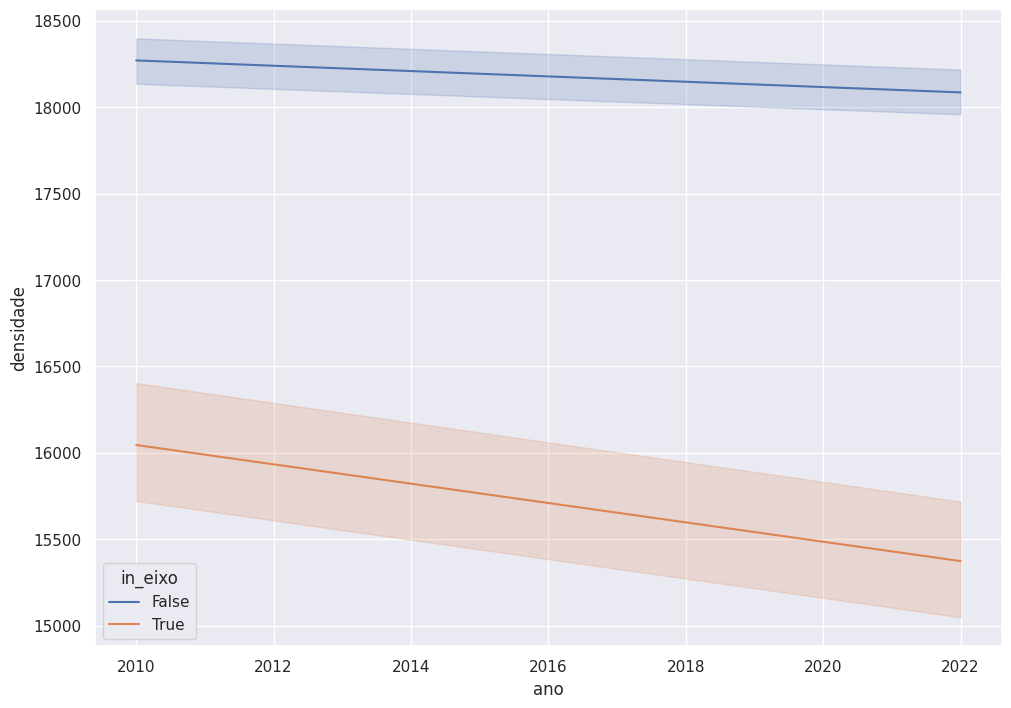

In [58]:
sns.lineplot(data=par_df, x="ano", y="densidade", hue="in_eixo")

# Avaliando as regressões

In [59]:
df_reg = (
    par_df[par_df['ano']>=2010]
)
df_reg

,cd_identificador_quadra_viaria_editada,in_eixo,has_tombamento,in_bairro_ambiental,pct_contamin,has_risco_geol,has_mataatl,has_area_ind,has_parq_uc,has_area_pub,ano,densidade
0,1,False,False,False,0.0,False,False,False,False,False,2010,12287.581699
1,21,False,False,False,0.0,False,False,False,False,True,2010,8749.069248
2,24,False,False,False,0.0,False,False,False,False,True,2010,8765.522279
3,26,False,False,False,0.0,False,False,False,False,True,2010,8752.735230
4,28,False,False,False,0.0,False,False,False,False,True,2010,8673.396843
...,...,...,...,...,...,...,...,...,...,...,...,...
93249,64768,False,False,False,0.0,True,True,False,True,True,2022,1457.941627
93250,64771,False,False,False,0.0,True,False,False,False,False,2022,15211.571225
93251,64772,False,False,False,0.0,True,False,False,False,False,2022,1929.696464
93252,64773,False,False,False,0.0,False,True,False,True,False,2022,2103.921295


## Analisando as variáveis de interesse e de tratamento

In [60]:
dens_std = df_reg['densidade'].describe()['std']
df_reg['densidade'].describe()

count     93254.000000
mean      17958.536867
std       13712.916309
min           0.000000
25%        9683.239913
50%       15879.640268
75%       22938.428498
max      711566.617862
Name: densidade, dtype: float64

<Axes: xlabel='densidade', ylabel='Count'>

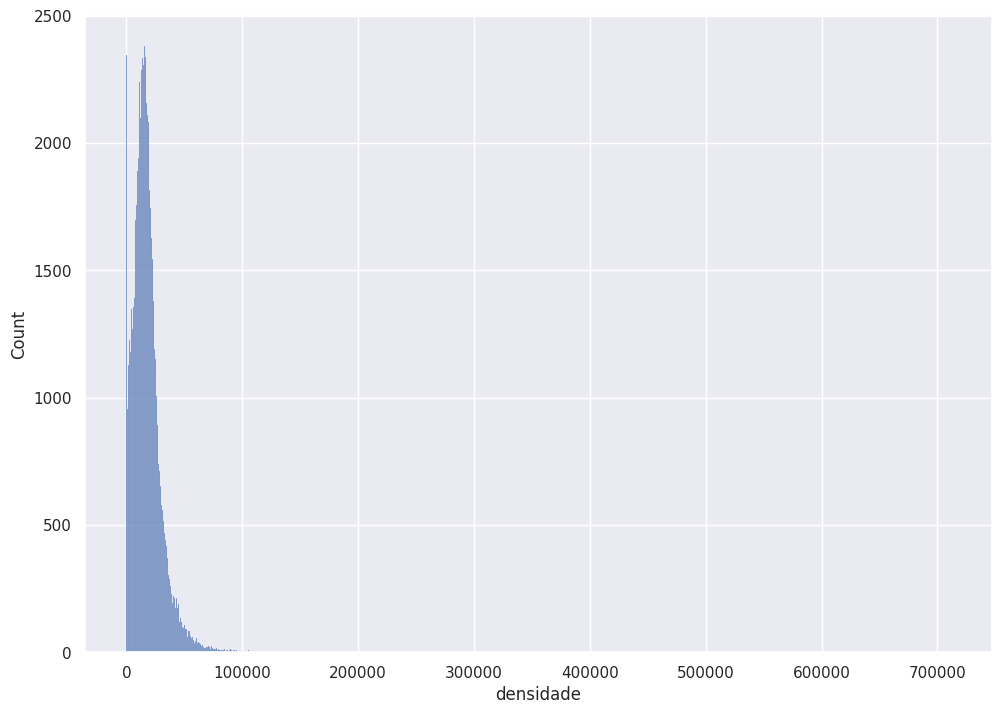

In [61]:
sns.histplot(data=df_reg, x='densidade')

Nossa variável de interesesse aparenta ser bastante assimétrica, além de não possuir valores negativos. Por isso, vamos adicionar uma versão transformada da variável para tornar o pressuposto de normalidade dos resíduos mais aceitável. De todo modo, vale ressaltar que o pressuposto de normalidade não causa nenhum viés nos estimadores dos parâmetros, interferindo apenas no estimador da matriz de covariância e nos testes estatísticos.

In [62]:
df_reg['log_densidade'] = np.log(df_reg['densidade'] + 1)
df_reg.head()

,cd_identificador_quadra_viaria_editada,in_eixo,has_tombamento,in_bairro_ambiental,pct_contamin,has_risco_geol,has_mataatl,has_area_ind,has_parq_uc,has_area_pub,ano,densidade,log_densidade
0,1,False,False,False,0.0,False,False,False,False,False,2010,12287.581699,9.416426
1,21,False,False,False,0.0,False,False,False,False,True,2010,8749.069248,9.076817
2,24,False,False,False,0.0,False,False,False,False,True,2010,8765.522279,9.078695
3,26,False,False,False,0.0,False,False,False,False,True,2010,8752.735230,9.077236
4,28,False,False,False,0.0,False,False,False,False,True,2010,8673.396843,9.068131


<Axes: xlabel='log_densidade', ylabel='Count'>

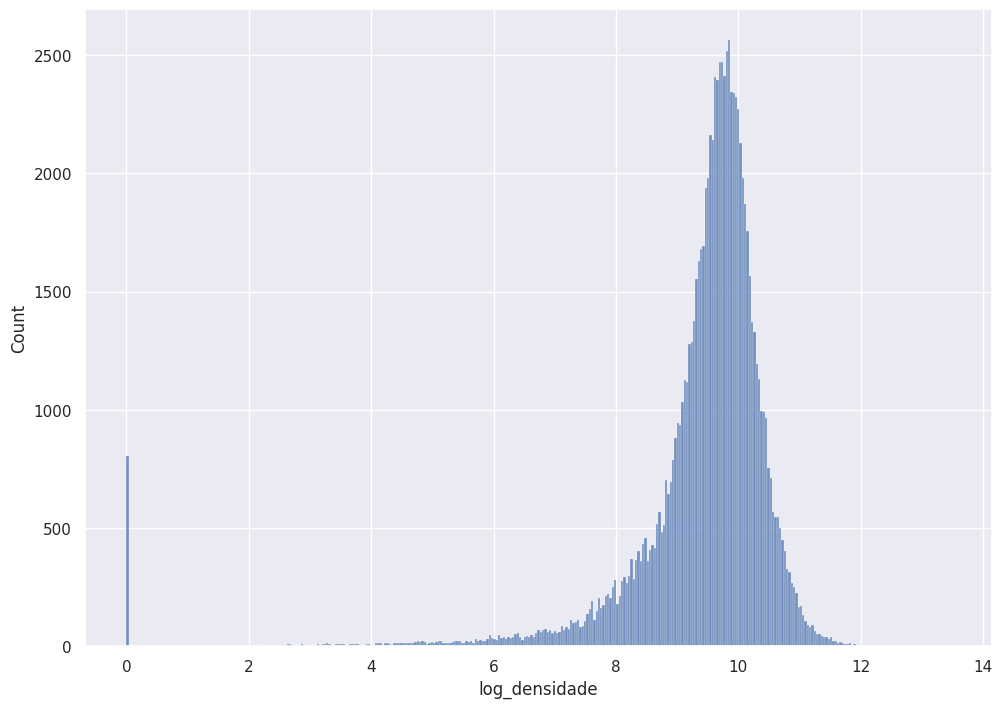

In [63]:
sns.histplot(data=df_reg, x='log_densidade')

In [64]:
log_dens_std = df_reg['log_densidade'].describe()['std']
df_reg['log_densidade'].describe()

count    93254.000000
mean         9.413254
std          1.316405
min          0.000000
25%          9.178255
50%          9.672856
75%         10.040612
max         13.475226
Name: log_densidade, dtype: float64

<Axes: xlabel='ano', ylabel='log_densidade'>

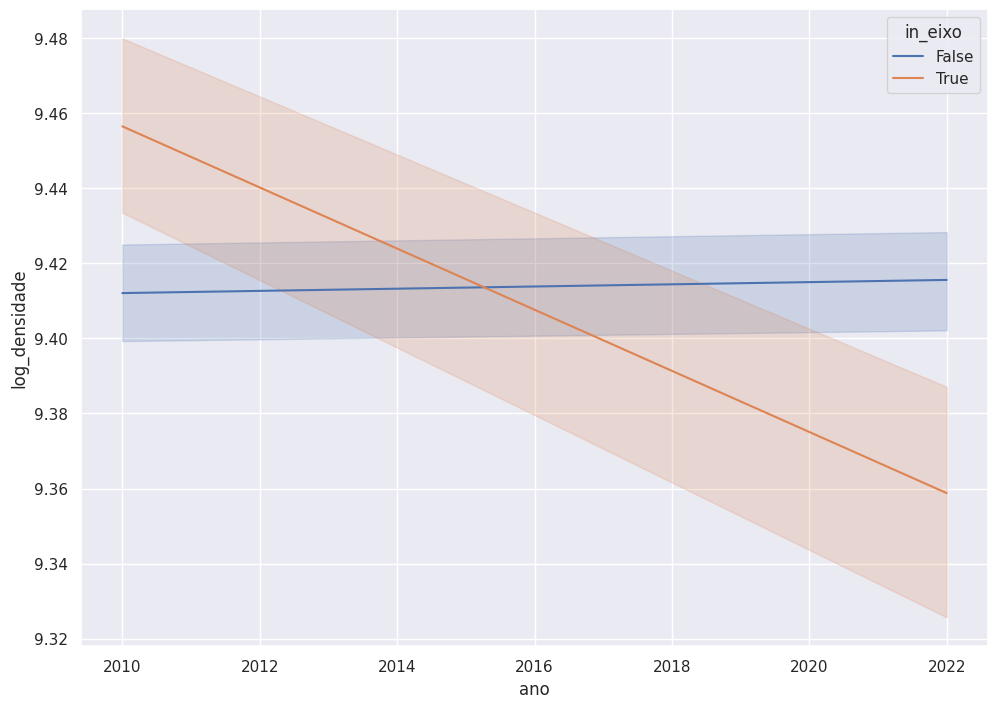

In [65]:
sns.lineplot(data=df_reg, x="ano", y="log_densidade", hue="in_eixo")

Como vemos, a tansformação da nossa variável de densidade utilizando logaritmo, apesar de se tratar de uma transformação monotônica, causou um efeito indesejado nos dados, alterando o sentido da variação no grupo controle entre os dois períodos. 

<Axes: xlabel='in_eixo', ylabel='Count'>

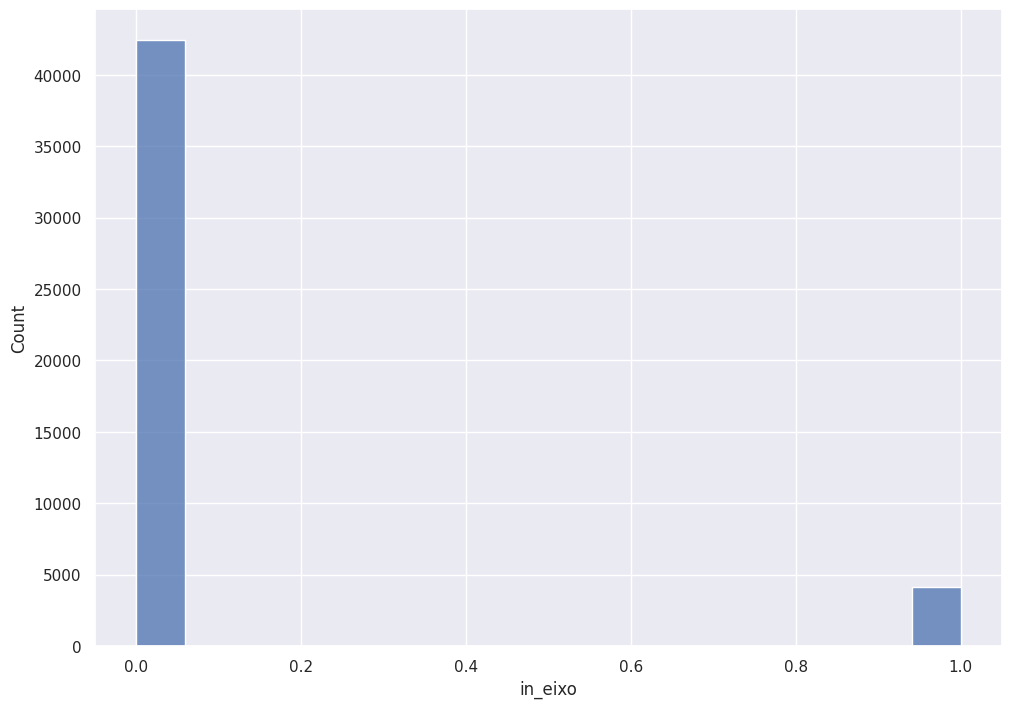

In [66]:
sns.histplot(data=df_reg.query('ano==2022'), x='in_eixo')

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<Axes: xlabel='densidade', ylabel='ano'>

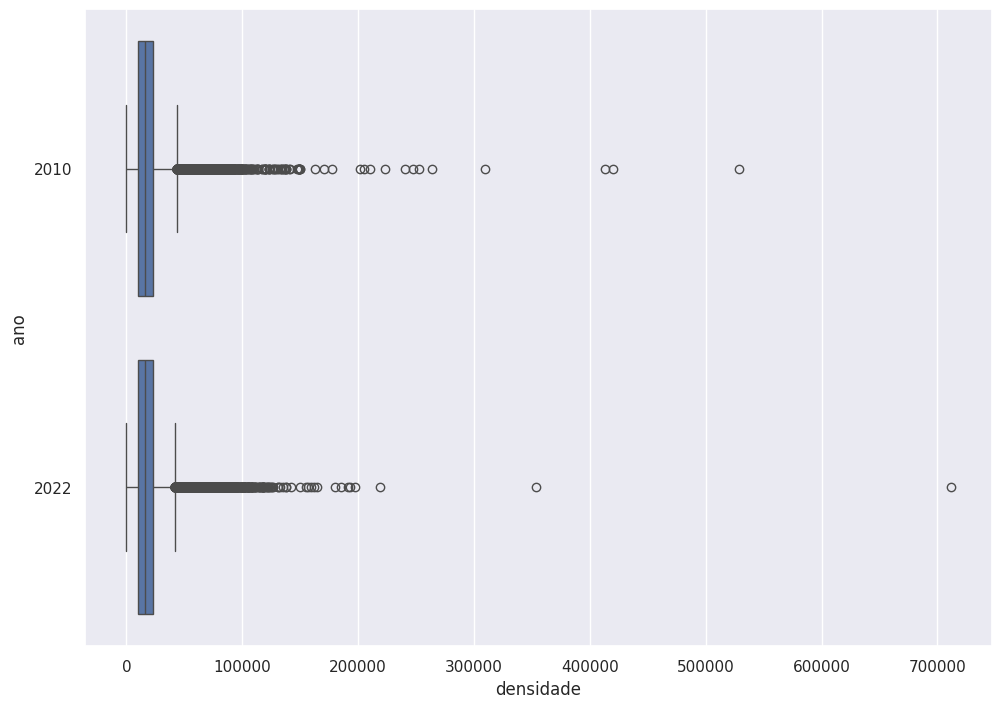

In [67]:
sns.boxplot(x=df_reg['densidade'],y=df_reg['ano'].astype(str))

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<Axes: xlabel='densidade', ylabel='ano'>

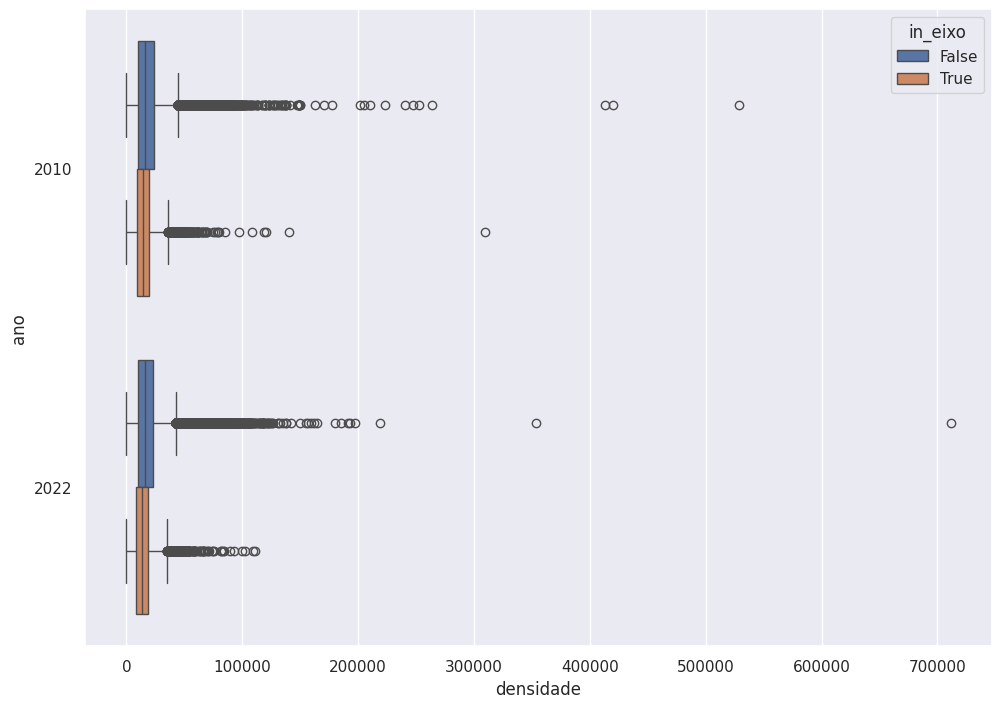

In [68]:
sns.boxplot(data=df_reg.assign(ano=df_reg['ano'].astype(str)), x='densidade',y='ano', hue='in_eixo')

## Modelo 1: DiD clássico

Nossa regressão se baseia no método de diferenças em diferenças clássico (2x2), já que temos dois grupos (quadras no eixo e quadras fora do eixo) e dois períodos. Adaptando um trecho de [Cunningham (2021)](https://mixtape.scunning.com/09-difference_in_differences#dd-and-the-minimum-wage), podemos ver que a regressão tem a seguinte forma:

$$Y_{itg} = \alpha + \gamma IE_g + \lambda (ano=2022)_t + \delta (IE \times (ano=2022))_{st} + \varepsilon_{ite}$$

Assim, temos:

1. $E[Y|in\_eixo=0,ano=2010]=\alpha$

1. $E[Y|in\_eixo=0,ano=2022]=\alpha + \lambda$

1. $E[Y|in\_eixo=1,ano=2010]=\alpha + \gamma$

1. $E[Y|in\_eixo=1,ano=2022]=\alpha + \gamma + \lambda + \delta$

Sendo o principal coeficiente avaliado o que representa a difererença entre variação dos dois grupos após o tratamento, ou seja:

$$(E[Y|in\_eixo=1,ano=2022]-E[Y|in\_eixo=1,ano=2010])-(E[Y|in\_eixo=0,ano=2022]-E[Y|in\_eixo=0,ano=2010]) = $$

$$ (\cancel\alpha + \cancel\gamma + \lambda + \delta - \cancel\alpha - \cancel\gamma) - (\cancel\alpha + \lambda - \cancel\alpha) = $$

$$ \cancel\lambda + \delta - \cancel\lambda  = \delta $$



In [69]:
df_reg

,cd_identificador_quadra_viaria_editada,in_eixo,has_tombamento,in_bairro_ambiental,pct_contamin,has_risco_geol,has_mataatl,has_area_ind,has_parq_uc,has_area_pub,ano,densidade,log_densidade
0,1,False,False,False,0.0,False,False,False,False,False,2010,12287.581699,9.416426
1,21,False,False,False,0.0,False,False,False,False,True,2010,8749.069248,9.076817
2,24,False,False,False,0.0,False,False,False,False,True,2010,8765.522279,9.078695
3,26,False,False,False,0.0,False,False,False,False,True,2010,8752.735230,9.077236
4,28,False,False,False,0.0,False,False,False,False,True,2010,8673.396843,9.068131
...,...,...,...,...,...,...,...,...,...,...,...,...,...
93249,64768,False,False,False,0.0,True,True,False,True,True,2022,1457.941627,7.285467
93250,64771,False,False,False,0.0,True,False,False,False,False,2022,15211.571225,9.629877
93251,64772,False,False,False,0.0,True,False,False,False,False,2022,1929.696464,7.565636
93252,64773,False,False,False,0.0,False,True,False,True,False,2022,2103.921295,7.652033


In [70]:
model_1 = (
    smf
    .ols('densidade ~ in_eixo*ano', data=df_reg)
)

In [71]:
model_1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              densidade   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     85.00
Date:                Fri, 21 Jun 2024   Prob (F-statistic):           6.49e-55
Time:                        23:53:39   Log-Likelihood:            -1.0205e+06
No. Observations:               93254   AIC:                         2.041e+06
Df Residuals:                   93250   BIC:                         2.041e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                    1.827e+04     66.449    274.966      0.000    1.81e+04    1.84e+04
in_eixo[T.True]             -2226.1251    222.624     -9.999      0.000   -2662.467   -1789.784
ano[T.2022]                  -185.2151     93.973     -1.971      0.049    -369.401      -1.029
in_eixo[T.True]:ano[T.2022]  -486.8032    314.839     -1.546      0.122   -1103.883     130.277
==============================================================================
Omnibus:                   104199.826   Durbin-Watson:                   1.498
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         63934797.300
Skew:                           5.071   Prob(JB):                         0.00
Kurtosis:                     130.873   Cond. No.                         9.27
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [72]:
model_1.fit(cov_type='HC0').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              densidade   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     119.0
Date:                Fri, 21 Jun 2024   Prob (F-statistic):           6.65e-77
Time:                        23:53:39   Log-Likelihood:            -1.0205e+06
No. Observations:               93254   AIC:                         2.041e+06
Df Residuals:                   93250   BIC:                         2.041e+06
Df Model:                           3                                         
Covariance Type:                  HC0                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                    1.827e+04     67.763    269.635      0.000    1.81e+04    1.84e+04
in_eixo[T.True]             -2226.1251    196.208    -11.346      0.000   -2610.686   -1841.565
ano[T.2022]                  -185.2151     95.343     -1.943      0.052    -372.084       1.653
in_eixo[T.True]:ano[T.2022]  -486.8032    268.749     -1.811      0.070   -1013.541      39.934
==============================================================================
Omnibus:                   104199.826   Durbin-Watson:                   1.498
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         63934797.300
Skew:                           5.071   Prob(JB):                         0.00
Kurtosis:                     130.873   Cond. No.                         9.27
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

In [73]:
(
    model_1
    .fit(cov_type='cluster', cov_kwds={'groups': df_reg['cd_identificador_quadra_viaria_editada']})
    .summary()
)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              densidade   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     85.48
Date:                Fri, 21 Jun 2024   Prob (F-statistic):           3.77e-55
Time:                        23:53:39   Log-Likelihood:            -1.0205e+06
No. Observations:               93254   AIC:                         2.041e+06
Df Residuals:                   93250   BIC:                         2.041e+06
Df Model:                           3                                         
Covariance Type:              cluster                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                    1.827e+04     67.764    269.628      0.000    1.81e+04    1.84e+04
in_eixo[T.True]             -2226.1251    196.213    -11.345      0.000   -2610.696   -1841.554
ano[T.2022]                  -185.2151     42.289     -4.380      0.000    -268.101    -102.329
in_eixo[T.True]:ano[T.2022]  -486.8032    135.559     -3.591      0.000    -752.494    -221.112
==============================================================================
Omnibus:                   104199.826   Durbin-Watson:                   1.498
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         63934797.300
Skew:                           5.071   Prob(JB):                         0.00
Kurtosis:                     130.873   Cond. No.                         9.27
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

**Nota sobre a matriz de covariância e os testes estatísticos**

Antes de analisar os resultados, vale um comentário adicional sobre os testes estatísticos dos parâmetros.

Além da normalidade (assintótica) dos resíduos, os estimadores da matriz de covariância só são corretos em caso não exista correlação serial entre os resíduos das observações de uma mesma unidade. Entretanto, é possível pensar em correlação serial mesmo em um modelo de DiD de dois grupos e dois períodos, como abordado em [Cunningham (2021)](https://mixtape.scunning.com/09-difference_in_differences#inference).

Ainda, [Bertrand, Duflo, and Mullainathan (2004)](https://academic.oup.com/qje/article-abstract/119/1/249/1876068]) demonstram que os estimadores tradicionais são sistematicamente subestimados e rejeitam a hipótese nula (isto é, rejeitam que $\delta=0$) em até 45% de intervenções placebo nas simulações.

Uma das alternativas propostas é utilizar erros padrão clusterizados nos grupo de intervenção, que foi feito acima, e outra é agregar os dados utilizando as médias dos grupos e períodos de tratamento. Entretanto, como temos apenas 1 grupo de intervenção, isso transformaria a matriz de variáveis independentes em uma matriz 2x2, o que torna impossível a estimação dos parâmetros devido ao número de observações.


De todo modo, as estimativas para $\delta$ (isto é, o efeito da inserção de uma quadra em um dos eixos ETU do Plano Diretor), não é estatísticamente significativo a nível 5% utilizando os erros padrão homocedásticos ou heterocedásticos. De todo modo, vale avaliarmos também a magnitude do efeito.

In [74]:
model_1.fit().params

Intercept                      18271.154574
in_eixo[T.True]                -2226.125128
ano[T.2022]                     -185.215083
in_eixo[T.True]:ano[T.2022]     -486.803183
dtype: float64

In [75]:
delta = model_1.fit().params.iloc[3]

In [76]:
delta/dens_std

-0.035499610153595484


O parâmetro foi estimado com sentido negativo, indicando uma *redução* na densidade populacional nas quadras pertencentes aos eixos ETU, que é o sentido contrário do esperado pelos formuladores do Plano. Porém, esse coeficiente representa apenas 0,03 desvio padrão da densidade populacional, o que significa que a variabilidade causada na densidade pelo pertencimento a um eixo ETU não tem relevância prática sobre a densidade populacional das quadras viárias.

## Modelo 2 e 3: associando apenas um cofator

In [77]:
model_2 = (
    smf
    .ols('densidade ~ in_eixo*ano + has_tombamento', data=df_reg)
)

In [78]:
model_2.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              densidade   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     108.6
Date:                Fri, 21 Jun 2024   Prob (F-statistic):           1.64e-92
Time:                        23:53:39   Log-Likelihood:            -1.0205e+06
No. Observations:               93254   AIC:                         2.041e+06
Df Residuals:                   93249   BIC:                         2.041e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                    1.837e+04     66.807    274.993      0.000    1.82e+04    1.85e+04
in_eixo[T.True]             -2165.7212    222.458     -9.735      0.000   -2601.737   -1729.706
ano[T.2022]                  -185.2151     93.883     -1.973      0.049    -369.225      -1.205
has_tombamento[T.True]      -3511.1912    262.452    -13.378      0.000   -4025.593   -2996.789
in_eixo[T.True]:ano[T.2022]  -486.8032    314.538     -1.548      0.122   -1103.295     129.689
==============================================================================
Omnibus:                   104570.790   Durbin-Watson:                   1.500
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         64545539.769
Skew:                           5.104   Prob(JB):                         0.00
Kurtosis:                     131.481   Cond. No.                         9.27
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [79]:
model_2.fit(cov_type='HC0').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              densidade   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     115.6
Date:                Fri, 21 Jun 2024   Prob (F-statistic):           1.51e-98
Time:                        23:53:39   Log-Likelihood:            -1.0205e+06
No. Observations:               93254   AIC:                         2.041e+06
Df Residuals:                   93249   BIC:                         2.041e+06
Df Model:                           4                                         
Covariance Type:                  HC0                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                    1.837e+04     67.669    271.489      0.000    1.82e+04    1.85e+04
in_eixo[T.True]             -2165.7212    197.090    -10.988      0.000   -2552.010   -1779.432
ano[T.2022]                  -185.2151     95.218     -1.945      0.052    -371.839       1.409
has_tombamento[T.True]      -3511.1912    346.755    -10.126      0.000   -4190.818   -2831.565
in_eixo[T.True]:ano[T.2022]  -486.8032    269.707     -1.805      0.071   -1015.419      41.812
==============================================================================
Omnibus:                   104570.790   Durbin-Watson:                   1.500
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         64545539.769
Skew:                           5.104   Prob(JB):                         0.00
Kurtosis:                     131.481   Cond. No.                         9.27
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

In [80]:
model_3 = (
    smf
    .ols('densidade ~ in_eixo*ano + in_eixo*has_tombamento', data=df_reg)
)

In [81]:
model_3.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              densidade   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     100.1
Date:                Fri, 21 Jun 2024   Prob (F-statistic):          1.33e-105
Time:                        23:53:39   Log-Likelihood:            -1.0204e+06
No. Observations:               93254   AIC:                         2.041e+06
Df Residuals:                   93248   BIC:                         2.041e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                1.84e+04     66.848    275.178      0.000    1.83e+04    1.85e+04
in_eixo[T.True]                        -2437.0755    224.893    -10.837      0.000   -2877.863   -1996.288
ano[T.2022]                             -185.2151     93.851     -1.974      0.048    -369.162      -1.268
has_tombamento[T.True]                 -4344.6848    281.838    -15.416      0.000   -4897.085   -3792.285
in_eixo[T.True]:ano[T.2022]             -486.8032    314.430     -1.548      0.122   -1103.082     129.476
in_eixo[T.True]:has_tombamento[T.True]  6246.1556    771.534      8.096      0.000    4733.957    7758.354
==============================================================================
Omnibus:                   104666.691   Durbin-Watson:                   1.500
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         64768774.936
Skew:                           5.112   Prob(JB):                         0.00
Kurtosis:                     131.703   Cond. No.                         20.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [82]:
model_3.fit(cov_type='HC0').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              densidade   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     103.3
Date:                Fri, 21 Jun 2024   Prob (F-statistic):          4.91e-109
Time:                        23:53:39   Log-Likelihood:            -1.0204e+06
No. Observations:               93254   AIC:                         2.041e+06
Df Residuals:                   93248   BIC:                         2.041e+06
Df Model:                           5                                         
Covariance Type:                  HC0                                         
==========================================================================================================
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                1.84e+04     67.720    271.634      0.000    1.83e+04    1.85e+04
in_eixo[T.True]                        -2437.0755    197.314    -12.351      0.000   -2823.804   -2050.348
ano[T.2022]                             -185.2151     95.213     -1.945      0.052    -371.830       1.400
has_tombamento[T.True]                 -4344.6848    383.837    -11.319      0.000   -5096.991   -3592.379
in_eixo[T.True]:ano[T.2022]             -486.8032    268.561     -1.813      0.070   -1013.174      39.567
in_eixo[T.True]:has_tombamento[T.True]  6246.1556    777.880      8.030      0.000    4721.539    7770.772
==============================================================================
Omnibus:                   104666.691   Durbin-Watson:                   1.500
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         64768774.936
Skew:                           5.112   Prob(JB):                         0.00
Kurtosis:                     131.703   Cond. No.                         20.0
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

## Modelos 4: associando todos os cofatores

In [83]:
no_inter = ' + '.join(covar)

model_4_formula = f'{y} ~ in_eixo*ano + {no_inter}'
model_4_formula

'densidade ~ in_eixo*ano + has_tombamento + in_bairro_ambiental + pct_contamin + has_risco_geol + has_mataatl + has_area_ind + has_parq_uc + has_area_pub'

In [84]:
model_4 = (
    smf
    .ols(model_4_formula, data=df_reg)
)

In [85]:
model_4.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              densidade   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     466.8
Date:                Fri, 21 Jun 2024   Prob (F-statistic):               0.00
Time:                        23:53:40   Log-Likelihood:            -1.0182e+06
No. Observations:               93254   AIC:                         2.036e+06
Df Residuals:                   93242   BIC:                         2.036e+06
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                    1.869e+04     67.126    278.398      0.000    1.86e+04    1.88e+04
in_eixo[T.True]             -2764.1699    217.960    -12.682      0.000   -3191.369   -2336.971
ano[T.2022]                  -185.2151     91.616     -2.022      0.043    -364.782      -5.648
has_tombamento[T.True]      -1425.7334    260.364     -5.476      0.000   -1936.044    -915.423
in_bairro_ambiental[T.True] -1.298e+04    371.196    -34.979      0.000   -1.37e+04   -1.23e+04
has_risco_geol[T.True]       7513.0996    305.824     24.567      0.000    6913.688    8112.511
has_mataatl[T.True]         -1.197e+04    234.190    -51.097      0.000   -1.24e+04   -1.15e+04
has_area_ind[T.True]        -8211.0160   1506.742     -5.450      0.000   -1.12e+04   -5257.818
has_parq_uc[T.True]           300.8308    258.406      1.164      0.244    -205.643     807.305
has_area_pub[T.True]         2757.7467    168.297     16.386      0.000    2427.886    3087.608
in_eixo[T.True]:ano[T.2022]  -486.8032    306.943     -1.586      0.113   -1088.408     114.802
pct_contamin                -4370.1019    823.087     -5.309      0.000   -5983.343   -2756.861
==============================================================================
Omnibus:                   108496.904   Durbin-Watson:                   1.531
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         80500443.994
Skew:                           5.421   Prob(JB):                         0.00
Kurtosis:                     146.528   Cond. No.                         39.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [86]:
model_4.fit(cov_type='HC0').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              densidade   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     1030.
Date:                Fri, 21 Jun 2024   Prob (F-statistic):               0.00
Time:                        23:53:40   Log-Likelihood:            -1.0182e+06
No. Observations:               93254   AIC:                         2.036e+06
Df Residuals:                   93242   BIC:                         2.036e+06
Df Model:                          11                                         
Covariance Type:                  HC0                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                    1.869e+04     67.301    277.674      0.000    1.86e+04    1.88e+04
in_eixo[T.True]             -2764.1699    194.832    -14.187      0.000   -3146.033   -2382.306
ano[T.2022]                  -185.2151     92.813     -1.996      0.046    -367.126      -3.304
has_tombamento[T.True]      -1425.7334    340.726     -4.184      0.000   -2093.545    -757.922
in_bairro_ambiental[T.True] -1.298e+04    161.721    -80.286      0.000   -1.33e+04   -1.27e+04
has_risco_geol[T.True]       7513.0996    554.377     13.552      0.000    6426.540    8599.659
has_mataatl[T.True]         -1.197e+04    290.873    -41.140      0.000   -1.25e+04   -1.14e+04
has_area_ind[T.True]        -8211.0160    684.255    -12.000      0.000   -9552.132   -6869.900
has_parq_uc[T.True]           300.8308    306.140      0.983      0.326    -299.192     900.854
has_area_pub[T.True]         2757.7467    203.842     13.529      0.000    2358.225    3157.269
in_eixo[T.True]:ano[T.2022]  -486.8032    266.890     -1.824      0.068   -1009.898      36.291
pct_contamin                -4370.1019   1142.296     -3.826      0.000   -6608.961   -2131.243
==============================================================================
Omnibus:                   108496.904   Durbin-Watson:                   1.531
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         80500443.994
Skew:                           5.421   Prob(JB):                         0.00
Kurtosis:                     146.528   Cond. No.                         39.8
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""